In [1]:
import nibabel as nib
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import pandas as pd
import torch.nn.functional as F
import torch.nn.parallel as parallel
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
import time
import os
import matplotlib.pyplot as plt
from IPython.display import display
from pathlib import Path
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import LinearLR, ChainedScheduler

In [2]:
class PatchEmbedding(nn.Module):
    def __init__(self, image_size=224, patch_size=16, in_channels=2, embed_dim=768):
        super().__init__()
        self.image_size = image_size
        self.patch_size = patch_size
        self.num_patches = (image_size // patch_size) ** 2
        
        self.projection = nn.Sequential(
            nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e h w -> b (h w) e')
        )
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.positions = nn.Parameter(torch.randn(self.num_patches + 1, embed_dim))
        
    def forward(self, x):
        b = x.shape[0]
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b=b)
        x = torch.cat([cls_tokens, x], dim=1)
        x += self.positions
        return x

In [3]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim=768, num_heads=12, dropout=0.1):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(embed_dim, embed_dim)
        
    def forward(self, x):
        qkv = self.qkv(x)
        qkv = rearrange(qkv, 'b n (h d qkv) -> qkv b h n d', 
                       h=self.num_heads, qkv=3)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        scaled_dot = torch.matmul(q, k.transpose(-1, -2)) * (self.head_dim ** -0.5)
        attention = F.softmax(scaled_dot, dim=-1)
        attention = self.att_drop(attention)
        
        x = torch.matmul(attention, v)
        x = rearrange(x, 'b h n d -> b n (h d)')
        x = self.projection(x)
        return x, attention

In [4]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim=768, num_heads=12, mlp_ratio=4, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadAttention(embed_dim, num_heads, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, int(embed_dim * mlp_ratio)),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(int(embed_dim * mlp_ratio), embed_dim),
            nn.Dropout(dropout)
        )
        
    def forward(self, x):
        x_norm = self.norm1(x)
        attn_output, attention = self.attn(x_norm)
        x = x + attn_output
        x = x + self.mlp(self.norm2(x))
        return x, attention

In [5]:
class VisionTransformer(nn.Module):
    def __init__(self, image_size=224, patch_size=16, in_channels=3, 
                 num_classes=1000, embed_dim=768, depth=12, 
                 num_heads=12, mlp_ratio=4, dropout=0.1):
        super().__init__()
        self.patch_embed = PatchEmbedding(
            image_size, patch_size, in_channels, embed_dim)
        self.transformer = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)
        
    def forward(self, x, return_attention=False):
        x = self.patch_embed(x)
        attention_maps = []
        
        for block in self.transformer:
            x, attention = block(x)
            attention_maps.append(attention)
            
        x = self.norm(x)
        cls_token = x[:, 0]
        output = self.head(cls_token)
        
        if return_attention:
            return output, attention_maps
        return output

In [6]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        def save_gradient(module, grad_input, grad_output):
            self.gradients = grad_output[0]
        
        def save_activation(module, input, output):
            if isinstance(output, tuple):
                self.activations = output[0]
            else:
                self.activations = output
        
        self.target_layer.register_forward_hook(save_activation)
        self.target_layer.register_full_backward_hook(save_gradient)
    
    def generate_cam(self, input_image, target_class):
        b, c, h, w = input_image.shape
        
        # Forward pass
        self.model.zero_grad()
        output, attention_maps = self.model(input_image, return_attention=True)
        
        # Target for backprop
        if target_class is None:
            target_class = output.argmax(dim=1)
            
        one_hot = torch.zeros_like(output)
        one_hot[0][target_class] = 1
        
        # Backward pass
        output.backward(gradient=one_hot, retain_graph=True)
        
        # Generate CAM
        with torch.no_grad():
            # Get gradients and activations
            gradients = self.gradients[0]  # [num_tokens, embed_dim]
            activations = self.activations[0]  # [num_tokens, embed_dim]
            
            # Remove CLS token
            gradients = gradients[1:]  # [num_patches, embed_dim]
            activations = activations[1:]  # [num_patches, embed_dim]
            
            # Calculate importance weights
            weights = gradients.mean(dim=0).unsqueeze(0)  # [1, embed_dim]
            
            # Weighted combination of activation maps
            cam = torch.matmul(activations, weights.transpose(0, 1))  # [num_patches]
            
            # Reshape to square grid
            num_patches = int(np.sqrt(cam.shape[0]))
            cam = cam.reshape(num_patches, num_patches)
            
            # Normalize
            cam = F.relu(cam)
            if torch.max(cam) != 0:  # Avoid division by zero
                cam = (cam - torch.min(cam)) / (torch.max(cam) - torch.min(cam))
            
            # Resize to input resolution
            cam = cam.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
            cam = F.interpolate(cam, size=(h, w), mode='bilinear', align_corners=False)
            cam = cam.squeeze()
            
        return cam, attention_maps

In [15]:
def save_training_metrics(batch_losses, epoch_losses, timestamp=None):
    """Save training metrics to CSV files"""
    if timestamp is None:
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    # Save batch losses
    batch_df = pd.DataFrame({'batch_number': range(len(batch_losses)), 'loss': batch_losses})
    batch_df.to_csv(f'batch_losses_{timestamp}.csv', index=False)
    
    # Save epoch losses
    epoch_df = pd.DataFrame({'epoch_number': range(len(epoch_losses)), 'loss': epoch_losses})
    epoch_df.to_csv(f'epoch_losses_{timestamp}.csv', index=False)
    
    return timestamp


def plot_training_metrics(csv_path, metric_type='batch', save_path=None, display=True):
    """Generate publication-quality training metric plots"""
    print(f"Reading metrics from: {csv_path}")
    df = pd.read_csv(csv_path)
    print(f"Found {len(df)} {metric_type} records")
    
    plt.figure(figsize=(12, 6))
    
    # Create the plot
    plt.plot(df[f'{metric_type}_number'], df['loss'], 
            color='#2671b8', linewidth=2, 
            marker='o' if metric_type == 'epoch' else None)
    
    # Customize the plot
    plt.title(f'{metric_type.capitalize()} Loss During Training', 
             fontsize=14, pad=20)
    plt.xlabel(f'{metric_type.capitalize()} Number', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Save the plot
    if save_path is None:
        save_path = f'{metric_type}_losses_plot_publication.pdf'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Saved plot to: {save_path}")
    
    # Display in notebook if requested
    if display:
        plt.show()
    else:
        plt.close()
        

def analyze_hemorrhage_with_gradcam(model, nifti_path, ground_truth_path=None):
    """
    Analyze a CT scan for hemorrhages with Grad-CAM, segmentation, and comprehensive visualization
    
    Args:
        model: Trained hemorrhage detection model
        nifti_path: Path to input NIfTI file
        ground_truth_path: Optional path to ground truth segmentation mask
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load and preprocess the image
    nifti_img = nib.load(nifti_path)
    image = nifti_img.get_fdata()
    
    # Take middle slice if 3D
    if len(image.shape) == 3:
        middle_slice = image.shape[2] // 2
        image = image[:, :, middle_slice]
    
    # Load ground truth if available
    ground_truth = None
    if ground_truth_path:
        try:
            gt_img = nib.load(ground_truth_path)
            ground_truth = gt_img.get_fdata()
            if len(ground_truth.shape) == 3:
                ground_truth = ground_truth[:, :, middle_slice]
            ground_truth = torch.from_numpy(ground_truth).float().to(device)
        except Exception as e:
            print(f"Warning: Could not load ground truth: {e}")
    
    # Create temporary dataset instance for window processing
    temp_dataset = ImprovedHemorrhageDataset(root_dir="", silent=True)
    
    # Use the prepare_image method to get both windows
    image = temp_dataset.prepare_image(image)
    
    # Prepare image tensor
    image = torch.from_numpy(image).float()
    image = image.unsqueeze(0)  # Add batch dimension
    original_size = image.shape[2:]  # Store original size for later
    image = F.interpolate(image, size=(224, 224), mode='bilinear', align_corners=False)
    image = image.to(device)
    
    # Initialize analyzers
    target_layer = model.module.vit.transformer[-1] if hasattr(model, 'module') else model.vit.transformer[-1]
    grad_cam = GradCAM(model, target_layer)
    seg_analyzer = SegmentationAnalyzer(model, device)
    
    # Get predictions and analysis for each hemorrhage type
    hemorrhage_types = ['epidural', 'intraparenchymal', 'intraventricular', 
                       'subarachnoid', 'subdural', 'any']
    results = []
    all_metrics = {}
    
    # Get initial predictions and attention maps
    with torch.no_grad():
        predictions = model(image)
        _, all_attention_maps = model(image, return_attention=True)
    
    # Print predictions and analyze each type
    print("\nPredicted Hemorrhage Types:")
    print("-" * 40)
    detected_types = []
    
    for idx, h_type in enumerate(hemorrhage_types):
        prob = predictions[0, idx].item()
        if prob > 0.3:  # Lower threshold for better detection
            detected_types.append(h_type)
            print(f"{h_type}: {prob:.3f}")
        
        try:
            # Generate Grad-CAM
            cam, attention_maps = grad_cam.generate_cam(image, target_class=idx)
            
            # Generate segmentation mask
            seg_mask = seg_analyzer.generate_segmentation_mask(attention_maps, original_size)
            refined_mask = seg_analyzer.refine_segmentation(seg_mask)
            
            # Calculate metrics if ground truth is available
            metrics = {}
            if ground_truth is not None:
                metrics = seg_analyzer.calculate_segmentation_metrics(refined_mask, ground_truth)
                all_metrics[h_type] = metrics
            
            results.append({
                'type': h_type,
                'probability': prob,
                'cam': cam,
                'attention_maps': attention_maps,
                'segmentation_mask': refined_mask,
                'metrics': metrics
            })
            
        except Exception as e:
            print(f"Warning: Error processing {h_type}: {e}")
            results.append({
                'type': h_type,
                'probability': prob,
                'cam': None,
                'attention_maps': None,
                'segmentation_mask': None,
                'metrics': {}
            })
    
    if not detected_types:
        print("No hemorrhages detected")
    
    # Prepare comprehensive output
    output = {
        'results': results,
        'image': image,
        'ground_truth': ground_truth,
        'attention_maps': all_attention_maps,
        'metrics': all_metrics
    }
    
    return output


def visualize_comprehensive_results(output, save_dir='analysis_results'):
    """Generate comprehensive visualizations for the analysis results"""
    os.makedirs(save_dir, exist_ok=True)
    
    try:
        # 1. Basic visualization for each hemorrhage type
        visualize_gradcam_results(output['image'], output['results'], 
                                save_dir=os.path.join(save_dir, 'gradcam'))
        
        # 2. Attention evolution visualization
        if 'attention_maps' in output and output['attention_maps']:
            plot_attention_evolution(
                output['attention_maps'],
                save_path=os.path.join(save_dir, 'attention_evolution.pdf')
            )
        
        # 3. Class activation visualization
        visualize_class_activation(
            output['results'],
            save_path=os.path.join(save_dir, 'class_activation.pdf')
        )
        
        # 4. Detailed attention heatmaps for detected types
        for result in output['results']:
            if result['probability'] > 0.3 and 'attention_maps' in result:
                create_attention_heatmap(
                    output['image'],
                    result['attention_maps'],
                    result['type'],
                    save_path=os.path.join(save_dir, f"attention_heatmap_{result['type']}.pdf")
                )
        
        # 5. Segmentation comparison if ground truth is available
        if output.get('ground_truth') is not None:
            for result in output['results']:
                if result['probability'] > 0.3 and 'segmentation_mask' in result:
                    visualize_segmentation_comparison(
                        output['image'],
                        result['segmentation_mask'],
                        output['ground_truth'],
                        result.get('metrics', {}),
                        save_path=os.path.join(save_dir, f"seg_comparison_{result['type']}.pdf")
                    )
    except Exception as e:
        print(f"Error in visualize_comprehensive_results: {e}")


def visualize_gradcam_results(image, results, save_dir='gradcam_results', display=True):
    """Visualize and save Grad-CAM results with enhanced image handling"""
    image = image.cpu().detach() if isinstance(image, torch.Tensor) else image
    os.makedirs(save_dir, exist_ok=True)
    
    # Better image normalization for visualization
    orig_image = image.squeeze().numpy()[0]  # Use brain window
    orig_image = np.clip(orig_image, 0, 1)  # Should already be normalized
    
    for result in results:
        h_type = result['type']
        prob = result['probability']
        cam = result['cam'].squeeze().cpu().detach().numpy()
        
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
        
        # Original CT scan
        ax1.imshow(orig_image, cmap='gray', vmin=0, vmax=1)
        ax1.set_title('Original CT Scan')
        ax1.axis('off')
        
        # Grad-CAM overlay
        ax2.imshow(orig_image, cmap='gray', vmin=0, vmax=1)
        cam_normalized = np.clip(cam, 0, 1)
        heatmap = ax2.imshow(cam_normalized, cmap='jet', alpha=0.4)
        ax2.set_title(f'{h_type} Hemorrhage\nProbability: {prob:.3f}')
        ax2.axis('off')
        plt.colorbar(heatmap, ax=ax2)
        
        # Attention map
        if result['attention_maps']:
            att_map = result['attention_maps'][-1][0, 0].mean(0).cpu().detach().numpy()
            att_size = int(np.sqrt(att_map.shape[0] - 1))
            att_map = att_map[1:].reshape(att_size, att_size)
            att_map = np.clip((att_map - att_map.min()) / (att_map.max() - att_map.min() + 1e-8), 0, 1)
            ax3.imshow(att_map, cmap='viridis')
            ax3.set_title('Attention Map')
            ax3.axis('off')
            plt.colorbar(plt.cm.ScalarMappable(cmap='viridis'), ax=ax3)
        
        plt.suptitle(f'Grad-CAM Visualization for {h_type} Hemorrhage', y=1.05)
        plt.tight_layout()
        
        save_path = os.path.join(save_dir, f'gradcam_{h_type.lower()}.pdf')
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        if display:
            plt.show()
        else:
            plt.close()
        
        print(f"Saved Grad-CAM visualization for {h_type} to {save_path}")
        
        
# Example usage:
def analyze_case(model, nifti_path, ground_truth_path=None):
    """Wrapper function to analyze a case and generate all visualizations"""
    print(f"Analyzing: {nifti_path}")
    
    # Run analysis
    output = analyze_hemorrhage_with_gradcam(model, nifti_path, ground_truth_path)
    
    # Generate visualizations
    save_dir = f"analysis_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    visualize_comprehensive_results(output, save_dir=save_dir)
    
    print(f"\nAnalysis complete. Results saved in: {save_dir}")
    return output

In [16]:
class ImprovedHemorrhageViT(nn.Module):
    def __init__(self, image_size=224, patch_size=16, in_channels=2, 
                 num_hemorrhage_types=6, embed_dim=768, depth=12, 
                 num_heads=12, mlp_ratio=4, dropout=0.2):
        super().__init__()
        self.vit = VisionTransformer(
            image_size=image_size,
            patch_size=patch_size,
            in_channels=in_channels,  # Changed to 2 for dual window inputs
            num_classes=embed_dim,
            embed_dim=embed_dim,
            depth=depth,
            num_heads=num_heads,
            mlp_ratio=mlp_ratio,
            dropout=dropout
        )
        
        # Improved classification head
        self.multilabel_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, embed_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim, embed_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim // 2, num_hemorrhage_types),
            nn.Sigmoid()
        )

    def forward(self, x, return_attention=False):
        if return_attention:
            features, attention_maps = self.vit(x, return_attention=True)
            output = self.multilabel_head(features)
            # Remove temperature scaling - it's making predictions too similar
            return output, attention_maps
        else:
            features = self.vit(x)
            output = self.multilabel_head(features)
            return output
        
    def prepare_image(self, image):
        # Normalize before windowing
        image = image - np.min(image)
        image = image / (np.max(image) + 1e-8)

        brain_window = self.window_image(image, window_center=0.4, window_width=0.8)
        subdural_window = self.window_image(image, window_center=0.8, window_width=0.2)
        combined_image = np.stack([brain_window, subdural_window], axis=0)
        return combined_image

    def window_image(self, image, window_center, window_width):
        img_min = window_center - window_width // 2
        img_max = window_center + window_width // 2
        window_image = np.clip(image, img_min, img_max)
        window_image = ((window_image - img_min) / (img_max - img_min) * 255).astype(np.uint8)
        return window_image

In [17]:
class ImprovedHemorrhageDataset(Dataset):
    def __init__(self, root_dir, transform=None, phase='train', split_ratio=0.8, silent=False):
        super().__init__()
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.phase = phase
        self.file_paths = []
        self.labels = []
        self.hemorrhage_types = ['epidural', 'intraparenchymal', 'intraventricular', 
                               'subarachnoid', 'subdural', 'any']
        self.target_size = (224, 224)
        
        self.patient_folders = [f for f in self.root_dir.iterdir() if f.is_dir()]
        
        if root_dir and not silent:
            print("Loading dataset...")
            self._load_dataset(split_ratio)
            print(f"Found {len(self.file_paths)} valid samples")
            
    def _load_dataset(self, split_ratio):
        all_files = []
        all_labels = []
        
        for patient_folder in self.patient_folders:
            nifti_files = list(patient_folder.glob(f"{patient_folder.name}_*.nii.gz"))
            if not nifti_files:
                continue
            
            labels_file = patient_folder / "hemorrhage_labels.csv"
            if not labels_file.exists():
                continue
                
            try:
                labels_df = pd.read_csv(labels_file)
                labels = [int(labels_df[labels_df['hemorrhage_type'] == htype]['label'].values[0])
                         for htype in self.hemorrhage_types]
                
                all_files.append(nifti_files[0])
                all_labels.append(labels)
            except Exception as e:
                print(f"Error processing {patient_folder}: {e}")
                continue
        
        # Split data based on phase
        num_samples = len(all_files)
        indices = np.random.permutation(num_samples)
        split_idx = int(split_ratio * num_samples)
        
        if self.phase == 'train':
            selected_indices = indices[:split_idx]
        else:  # validation
            selected_indices = indices[split_idx:]
            
        self.file_paths = [all_files[i] for i in selected_indices]
        self.labels = [all_labels[i] for i in selected_indices]

    def window_image(self, image, window_center, window_width):
        """Apply window/level transform to image"""
        min_value = window_center - window_width / 2.0
        max_value = window_center + window_width / 2.0
        windowed = np.clip(image, min_value, max_value)
        return (windowed - min_value) / (window_width + 1e-8)

    def prepare_image(self, image):
        """Enhanced image preprocessing with better normalization"""
        # Initial normalization
        min_val = np.percentile(image, 1)  # Use percentile to avoid outliers
        max_val = np.percentile(image, 99)
        image = np.clip(image, min_val, max_val)
        image = (image - min_val) / (max_val - min_val + 1e-8)

        # CT Window settings
        brain_window = self.window_image(image, window_center=0.5, window_width=0.8)
        subdural_window = self.window_image(image, window_center=0.7, window_width=0.3)

        # Ensure values are in [0, 1] range
        brain_window = np.clip(brain_window, 0, 1)
        subdural_window = np.clip(subdural_window, 0, 1)

        return np.stack([brain_window, subdural_window], axis=0)

    def __getitem__(self, idx):
        nifti_path = self.file_paths[idx]
        nifti_img = nib.load(nifti_path)
        image = nifti_img.get_fdata()

        if len(image.shape) == 3:
            middle_slice = image.shape[2] // 2
            image = image[:, :, middle_slice]

        # Enhanced preprocessing
        image = self.prepare_image(image)
        image = torch.from_numpy(image).float()

        # Ensure image is of correct size
        if image.shape[1:] != self.target_size:
            image = F.interpolate(
                image.unsqueeze(0),
                size=self.target_size,
                mode='bilinear',
                align_corners=False
            ).squeeze(0)

        # Apply transforms if any
        if self.phase == 'train' and self.transform:
            image = self.transform(image)

        labels = torch.tensor(self.labels[idx], dtype=torch.float32)
        return image, labels

    def __len__(self):
        """Return the total number of samples in the dataset"""
        return len(self.file_paths)

In [18]:
class MultiChannelRandomHorizontalFlip:
    def __init__(self, p=0.5):
        self.p = p
        
    def __call__(self, image):
        if torch.rand(1) < self.p:
            return torch.flip(image, dims=[2])  # Flip along width dimension
        return image

class MultiChannelRandomVerticalFlip:
    def __init__(self, p=0.5):
        self.p = p
        
    def __call__(self, image):
        if torch.rand(1) < self.p:
            return torch.flip(image, dims=[1])  # Flip along height dimension
        return image

class MultiChannelRandomRotation:
    def __init__(self, degrees):
        self.degrees = degrees
        
    def __call__(self, image):
        angle = torch.rand(1) * 2 * self.degrees - self.degrees
        return transforms.functional.rotate(image, angle.item())

In [19]:
# Define loss function at module level
class WeightedBCELoss(nn.Module):
    def __init__(self, weights):
        super().__init__()
        self.register_buffer('weights', torch.stack(weights))

    def forward(self, outputs, targets):
        eps = 1e-7
        outputs = torch.clamp(outputs, eps, 1-eps)
        
        # Apply focal loss components
        gamma = 2.0
        alpha = 0.25
        
        loss = 0
        for i in range(outputs.shape[1]):
            weight = self.weights[i][targets[:, i].long()]
            pt = outputs[:, i] * targets[:, i] + (1 - outputs[:, i]) * (1 - targets[:, i])
            focal_weight = (1 - pt) ** gamma
            
            pos_loss = -alpha * weight * focal_weight * targets[:, i] * torch.log(outputs[:, i])
            neg_loss = -(1 - alpha) * weight * focal_weight * (1 - targets[:, i]) * torch.log(1 - outputs[:, i])
            
            loss += (pos_loss + neg_loss).mean()
            
        return loss / outputs.shape[1]

def setup_dataloaders(root_dir, batch_size, train_transform):
    """Setup train and validation dataloaders"""
    train_dataset = ImprovedHemorrhageDataset(
        root_dir=root_dir, 
        transform=train_transform, 
        phase='train'
    )
    
    val_dataset = ImprovedHemorrhageDataset(
        root_dir=root_dir, 
        transform=None,
        phase='val'
    )

    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    
    return train_loader, val_loader, train_dataset

def validate_model(model, val_loader, criterion, device):
    """Run validation phase"""
    model.eval()
    val_loss = 0.0
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            predictions.extend(outputs.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    return val_loss / len(val_loader), np.array(predictions), np.array(true_labels)

def calculate_class_weights(labels):
    class_weights = []
    for i in range(labels.shape[1]):
        pos_count = np.sum(labels[:, i] == 1)
        neg_count = np.sum(labels[:, i] == 0)
        total = pos_count + neg_count
        
        # Effective number based weighting
        beta = 0.9999
        effective_pos = (1 - beta**pos_count) / (1 - beta) if pos_count > 0 else 1.0
        effective_neg = (1 - beta**neg_count) / (1 - beta) if neg_count > 0 else 1.0
        
        # Scale weights
        pos_weight = (total / effective_pos) if pos_count > 0 else 1.0
        neg_weight = (total / effective_neg) if neg_count > 0 else 1.0
        
        # Normalize
        max_weight = max(pos_weight, neg_weight)
        pos_weight /= max_weight
        neg_weight /= max_weight
        
        class_weights.append(torch.FloatTensor([neg_weight, pos_weight]))
    return class_weights


def train_improved_model(root_dir, num_epochs=20, batch_size=16, learning_rate=1e-5):  # Reduced learning rate
    # Setup timestamp and loss tracking
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    batch_losses, epoch_losses = [], []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Setup data augmentation
    train_transform = transforms.Compose([
        MultiChannelRandomHorizontalFlip(p=0.5),
        MultiChannelRandomVerticalFlip(p=0.5),
        MultiChannelRandomRotation(degrees=45),
        transforms.Normalize(mean=[0.485, 0.485], std=[0.229, 0.229])
    ])

    # Setup data
    train_loader, val_loader, train_dataset = setup_dataloaders(root_dir, batch_size, train_transform)
    print(f"Training batches per epoch: {len(train_loader)}")
    print(f"Validation batches per epoch: {len(val_loader)}")
    
    # Setup model and training components
    model = ImprovedHemorrhageViT(in_channels=2).to(device)
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs!")
        model = nn.DataParallel(model)
    
    # Calculate class weights and setup loss
    class_weights = calculate_class_weights(np.array(train_dataset.labels))
    criterion = WeightedBCELoss(class_weights).to(device)
    
    # Setup optimizer and scheduler
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
    scheduler = lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=learning_rate,
        epochs=num_epochs,
        steps_per_epoch=len(train_loader),
        pct_start=0.3,  # Spend 30% of time warming up
        div_factor=25,  # Start with lr/25
        final_div_factor=1e4  # End with lr/10000
    )
    
    # Training setup
    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0
    hemorrhage_types = ['epidural', 'intraparenchymal', 'intraventricular', 
                       'subarachnoid', 'subdural', 'any']

    # Training loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_metrics = {
            'loss': 0.0,
            'class_correct': np.zeros(6),
            'class_total': np.zeros(6),
            'predictions': []
        }
        
        with tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}') as pbar:
            for step, (images, labels) in enumerate(pbar):
                images, labels = images.to(device), labels.to(device)
                
                # Forward pass
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                # Backward pass
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                scheduler.step()
                
                # Update metrics
                train_metrics['loss'] += loss.item()
                predictions = (outputs > 0.5).float()
                for i in range(6):
                    train_metrics['class_correct'][i] += ((predictions[:, i] == labels[:, i]).sum().item())
                    train_metrics['class_total'][i] += labels.size(0)
                
                batch_losses.append(loss.item())
                pbar.set_postfix({
                    'train_loss': f'{loss.item():.4f}',
                    'lr': f'{optimizer.param_groups[0]["lr"]:.2e}'
                })
        
        # Calculate average training loss and metrics
        avg_train_loss = train_metrics['loss'] / len(train_loader)
        epoch_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_metrics = {
            'loss': 0.0,
            'class_correct': np.zeros(6),
            'class_total': np.zeros(6),
            'predictions': [],
            'true_labels': []
        }
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_metrics['loss'] += loss.item()
                
                # Class-wise metrics
                predictions = (outputs > 0.5).float()
                for i in range(6):
                    val_metrics['class_correct'][i] += ((predictions[:, i] == labels[:, i]).sum().item())
                    val_metrics['class_total'][i] += labels.size(0)
                
                val_metrics['predictions'].extend(outputs.cpu().numpy())
                val_metrics['true_labels'].extend(labels.cpu().numpy())
        
        avg_val_loss = val_metrics['loss'] / len(val_loader)
        
        # Print detailed metrics
        print(f'\nEpoch {epoch+1} Summary:')
        print(f'Average Training Loss: {avg_train_loss:.4f}')
        print(f'Average Validation Loss: {avg_val_loss:.4f}')
        print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.2e}')
        
        print("\nTraining Metrics:")
        for i, htype in enumerate(hemorrhage_types):
            train_acc = train_metrics['class_correct'][i] / train_metrics['class_total'][i]
            print(f'{htype}: {train_acc:.4f}')
            
        print("\nValidation Metrics:")
        for i, htype in enumerate(hemorrhage_types):
            val_acc = val_metrics['class_correct'][i] / val_metrics['class_total'][i]
            print(f'{htype}: {val_acc:.4f}')
        
        # Early stopping and model saving
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            print(f'New best validation loss: {best_val_loss:.4f}')
            
            # Save comprehensive checkpoint
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'class_weights': class_weights,
                'batch_losses': batch_losses,
                'epoch_losses': epoch_losses,
                'training_metrics': train_metrics,
                'validation_metrics': val_metrics,
                'learning_rate': optimizer.param_groups[0]["lr"],
            }, f'best_model_{timestamp}.pth')
            
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("\nEarly stopping triggered!")
                break
    
    # Save final metrics
    save_training_metrics(batch_losses, epoch_losses, timestamp)
    print("\nTraining completed!")
    
    return model, timestamp

In [25]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import seaborn as sns
from scipy.ndimage import binary_dilation, binary_erosion
import cv2
from skimage import measure
from matplotlib.patches import Rectangle
import pandas as pd

class SegmentationAnalyzer:
    def __init__(self, model, device):
        self.model = model
        self.device = device
        self.attention_threshold = 0.5
        
    def generate_segmentation_mask(self, attention_maps, image_size):
        """Convert attention maps to segmentation mask"""
        # Use the last layer's attention maps (usually most semantic)
        last_attention = attention_maps[-1]
        
        # Average attention across all heads
        avg_attention = last_attention.mean(dim=1)  # [B, N, N]
        
        # Remove CLS token attention
        patch_attention = avg_attention[:, 1:, 1:]  # Remove CLS token row and column
        
        # Reshape to square grid
        patch_size = int(np.sqrt(patch_attention.shape[1]))
        attention_grid = patch_attention.reshape(-1, patch_size, patch_size)
        
        # Upscale to original image size
        mask = F.interpolate(
            attention_grid.unsqueeze(1),
            size=image_size,
            mode='bilinear',
            align_corners=False
        ).squeeze(1)
        
        return mask

    def refine_segmentation(self, mask, threshold=0.5):
        """Refine segmentation mask using morphological operations"""
        binary_mask = (mask > threshold).cpu().numpy().astype(np.uint8)
        
        # Remove small objects
        labeled_mask = measure.label(binary_mask)
        props = measure.regionprops(labeled_mask)
        
        # Keep only larger connected components
        for prop in props:
            if prop.area < 50:  # Adjust threshold as needed
                binary_mask[labeled_mask == prop.label] = 0
        
        # Morphological operations
        kernel = np.ones((3, 3), np.uint8)
        refined_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
        refined_mask = cv2.morphologyEx(refined_mask, cv2.MORPH_OPEN, kernel)
        
        return torch.tensor(refined_mask, device=mask.device)

    def calculate_segmentation_metrics(self, pred_mask, ground_truth):
        """Calculate segmentation metrics"""
        pred_mask = pred_mask.cpu().numpy()
        ground_truth = ground_truth.cpu().numpy()
        
        # Calculate metrics
        intersection = np.logical_and(pred_mask, ground_truth)
        union = np.logical_or(pred_mask, ground_truth)
        
        iou = np.sum(intersection) / (np.sum(union) + 1e-10)
        dice = 2 * np.sum(intersection) / (np.sum(pred_mask) + np.sum(ground_truth) + 1e-10)
        
        return {
            'iou': iou,
            'dice': dice,
            'precision': np.sum(intersection) / (np.sum(pred_mask) + 1e-10),
            'recall': np.sum(intersection) / (np.sum(ground_truth) + 1e-10)
        }

def visualize_segmentation_comparison(image, pred_mask, ground_truth, metrics, save_path=None):
    """Create comprehensive visualization comparing prediction with ground truth"""
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Hemorrhage Segmentation Analysis', fontsize=16)
    
    # Original image with ground truth overlay
    axes[0, 0].imshow(image.squeeze().cpu(), cmap='gray')
    axes[0, 0].contour(ground_truth.squeeze().cpu(), colors='r', levels=[0.5], alpha=0.6)
    axes[0, 0].set_title('Original with Ground Truth')
    axes[0, 0].axis('off')
    
    # Original image with prediction overlay
    axes[0, 1].imshow(image.squeeze().cpu(), cmap='gray')
    axes[0, 1].contour(pred_mask.squeeze().cpu(), colors='b', levels=[0.5], alpha=0.6)
    axes[0, 1].set_title('Original with Prediction')
    axes[0, 1].axis('off')
    
    # Difference map
    diff_map = torch.abs(pred_mask - ground_truth).cpu()
    axes[0, 2].imshow(diff_map.squeeze(), cmap='RdYlBu', vmin=0, vmax=1)
    axes[0, 2].set_title('Difference Map')
    axes[0, 2].axis('off')
    plt.colorbar(plt.cm.ScalarMappable(cmap='RdYlBu'), ax=axes[0, 2])
    
    # Metrics visualization
    metrics_text = '\n'.join([f'{k}: {v:.3f}' for k, v in metrics.items()])
    axes[1, 0].text(0.1, 0.5, metrics_text, fontsize=12, va='center')
    axes[1, 0].axis('off')
    
    # ROC curve
    fpr, tpr, _ = roc_curve(ground_truth.cpu().numpy().ravel(), 
                           pred_mask.cpu().numpy().ravel())
    roc_auc = auc(fpr, tpr)
    axes[1, 1].plot(fpr, tpr, color='darkorange', lw=2, 
                    label=f'ROC curve (AUC = {roc_auc:.2f})')
    axes[1, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[1, 1].set_xlim([0.0, 1.0])
    axes[1, 1].set_ylim([0.0, 1.05])
    axes[1, 1].set_xlabel('False Positive Rate')
    axes[1, 1].set_ylabel('True Positive Rate')
    axes[1, 1].set_title('ROC Curve')
    axes[1, 1].legend(loc="lower right")
    
    # Precision-Recall curve
    precision, recall, _ = precision_recall_curve(ground_truth.cpu().numpy().ravel(),
                                                pred_mask.cpu().numpy().ravel())
    pr_auc = auc(recall, precision)
    axes[1, 2].plot(recall, precision, color='blue', lw=2,
                    label=f'PR curve (AUC = {pr_auc:.2f})')
    axes[1, 2].set_xlabel('Recall')
    axes[1, 2].set_ylabel('Precision')
    axes[1, 2].set_title('Precision-Recall Curve')
    axes[1, 2].legend(loc="lower left")
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def create_attention_heatmap(image, attention_maps, h_type, save_path=None):
    """Create and visualize attention heatmap for specific hemorrhage type"""
    try:
        plt.figure(figsize=(15, 5))
        
        # Left subplot: Original Image (brain window)
        plt.subplot(131)
        plt.imshow(image[0, 0].cpu(), cmap='gray')  # First channel (brain window)
        plt.title('Brain Window')
        plt.axis('off')
        
        # Middle subplot: Original Image (subdural window)
        plt.subplot(132)
        plt.imshow(image[0, 1].cpu(), cmap='gray')  # Second channel (subdural window)
        plt.title('Subdural Window')
        plt.axis('off')
        
        # Right subplot: Attention Heatmap
        plt.subplot(133)
        
        if attention_maps and len(attention_maps) > 0:
            # Get last layer's attention
            last_attention = attention_maps[-1]  # [1, 12, 197, 197]
            
            # Average across heads
            avg_attention = last_attention[0].mean(0)  # [197, 197]
            
            # Remove CLS token and reshape
            patch_attention = avg_attention[1:, 1:]  # [196, 196]
            size = int(np.sqrt(patch_attention.shape[0]))
            attention_grid = patch_attention.reshape(size, size)
            
            # Create heatmap
            sns.heatmap(attention_grid.cpu().detach(), cmap='viridis', cbar=True)
            plt.title(f'Attention Heatmap for {h_type}')
        else:
            plt.text(0.5, 0.5, 'No attention maps available', ha='center', va='center')
        
        plt.axis('off')
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()
    except Exception as e:
        print(f"Error in create_attention_heatmap for {h_type}: {str(e)}")


def visualize_class_activation(results, save_path=None):
    """Create class activation visualization for all hemorrhage types"""
    hemorrhage_types = ['epidural', 'intraparenchymal', 'intraventricular', 
                       'subarachnoid', 'subdural', 'any']
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Class Activation Maps for Different Hemorrhage Types', fontsize=16)
    
    for idx, (ax, h_type) in enumerate(zip(axes.ravel(), hemorrhage_types)):
        try:
            result = results[idx]
            if result['type'] != h_type:
                print(f"Warning: Type mismatch {result['type']} != {h_type}")
                continue
                
            cam = result['cam'].cpu().detach()
            prob = result['probability']
            
            im = ax.imshow(cam, cmap='jet')
            ax.set_title(f'{h_type}\nProbability: {prob:.3f}')
            plt.colorbar(im, ax=ax)
            ax.axis('off')
        except Exception as e:
            print(f"Warning: Could not process activation map for {h_type}: {e}")
            ax.text(0.5, 0.5, 'No Data', ha='center', va='center')
            ax.axis('off')
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()

def plot_attention_evolution(attention_maps, save_path=None):
    """Visualize how attention evolves through transformer layers"""
    try:
        num_layers = len(attention_maps)
        rows = (num_layers + 3) // 4
        cols = min(4, num_layers)
        
        fig, axes = plt.subplots(rows, cols, figsize=(20, 5*rows))
        fig.suptitle('Evolution of Attention Maps Across Transformer Layers', fontsize=16)
        
        if rows == 1:
            axes = [axes]
        axes = np.array(axes).flatten()
        
        for idx, ax in enumerate(axes):
            if idx < num_layers:
                try:
                    # Get attention map for this layer
                    att_map = attention_maps[idx]  # [1, 12, 197, 197]
                    
                    # Average across heads
                    avg_attention = att_map[0].mean(0)  # [197, 197]
                    
                    # Remove CLS token
                    patch_attention = avg_attention[1:, 1:]  # [196, 196]
                    
                    # Reshape to grid (14x14 for 224x224 image with patch size 16)
                    size = int(np.sqrt(patch_attention.shape[0]))
                    attention_grid = patch_attention.reshape(size, size)
                    
                    # Plot
                    im = ax.imshow(attention_grid.cpu().detach(), cmap='viridis')
                    ax.set_title(f'Layer {idx + 1}')
                    plt.colorbar(im, ax=ax)
                except Exception as e:
                    print(f"Warning: Could not process attention map for layer {idx}: {e}")
                    ax.text(0.5, 0.5, 'Error', ha='center', va='center')
            ax.axis('off')
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()
    except Exception as e:
        print(f"Error in plot_attention_evolution: {e}")

def create_model_summary(model, results_df, save_path=None):
    """Create comprehensive model performance summary"""
    plt.figure(figsize=(15, 10))
    
    # Performance metrics by hemorrhage type
    metrics = ['precision', 'recall', 'f1_score', 'auc']
    hemorrhage_types = ['epidural', 'intraparenchymal', 'intraventricular', 
                       'subarachnoid', 'subdural', 'any']
    
    data = []
    for metric in metrics:
        for h_type in hemorrhage_types:
            data.append({
                'Metric': metric,
                'Type': h_type,
                'Value': results_df.loc[h_type, metric]
            })
    
    df = pd.DataFrame(data)
    
    # Create heatmap
    pivot_table = df.pivot(index='Type', columns='Metric', values='Value')
    sns.heatmap(pivot_table, annot=True, cmap='YlOrRd', fmt='.3f')
    plt.title('Model Performance Summary')
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

Starting model training...
Using device: cuda
Loading dataset...
Found 1464 valid samples
Loading dataset...
Found 367 valid samples
Training samples: 1464
Validation samples: 367
Training batches per epoch: 92
Validation batches per epoch: 23


Epoch 1/20: 100%|██████████| 92/92 [01:02<00:00,  1.47it/s, train_loss=0.0212, lr=1.05e-05]



Epoch 1 Summary:
Average Training Loss: 0.0199
Average Validation Loss: 0.0233
Learning Rate: 1.05e-05

Training Metrics:
epidural: 0.5861
intraparenchymal: 0.8531
intraventricular: 0.9242
subarachnoid: 0.8094
subdural: 0.8169
any: 0.6339

Validation Metrics:
epidural: 0.9918
intraparenchymal: 0.8883
intraventricular: 0.9619
subarachnoid: 0.9292
subdural: 0.8229
any: 0.5940
New best validation loss: 0.0233


Epoch 2/20: 100%|██████████| 92/92 [01:03<00:00,  1.44it/s, train_loss=0.0206, lr=2.81e-05]



Epoch 2 Summary:
Average Training Loss: 0.0179
Average Validation Loss: 0.0207
Learning Rate: 2.81e-05

Training Metrics:
epidural: 0.9440
intraparenchymal: 0.8620
intraventricular: 0.9310
subarachnoid: 0.9173
subdural: 0.7958
any: 0.7650

Validation Metrics:
epidural: 0.9918
intraparenchymal: 0.8883
intraventricular: 0.9619
subarachnoid: 0.9292
subdural: 0.8229
any: 0.5940
New best validation loss: 0.0207


Epoch 3/20: 100%|██████████| 92/92 [01:01<00:00,  1.49it/s, train_loss=0.0189, lr=5.21e-05]



Epoch 3 Summary:
Average Training Loss: 0.0176
Average Validation Loss: 0.0221
Learning Rate: 5.21e-05

Training Metrics:
epidural: 0.9255
intraparenchymal: 0.8723
intraventricular: 0.9481
subarachnoid: 0.9180
subdural: 0.7876
any: 0.7773

Validation Metrics:
epidural: 0.9918
intraparenchymal: 0.8883
intraventricular: 0.9619
subarachnoid: 0.9292
subdural: 0.8229
any: 0.5940


Epoch 4/20: 100%|██████████| 92/92 [01:01<00:00,  1.48it/s, train_loss=0.0161, lr=7.62e-05]



Epoch 4 Summary:
Average Training Loss: 0.0177
Average Validation Loss: 0.0218
Learning Rate: 7.62e-05

Training Metrics:
epidural: 0.9542
intraparenchymal: 0.8634
intraventricular: 0.9160
subarachnoid: 0.8982
subdural: 0.7930
any: 0.7842

Validation Metrics:
epidural: 0.9918
intraparenchymal: 0.8883
intraventricular: 0.9619
subarachnoid: 0.9292
subdural: 0.8229
any: 0.5940


Epoch 5/20: 100%|██████████| 92/92 [01:01<00:00,  1.49it/s, train_loss=0.0098, lr=9.37e-05]



Epoch 5 Summary:
Average Training Loss: 0.0175
Average Validation Loss: 0.0230
Learning Rate: 9.37e-05

Training Metrics:
epidural: 0.9816
intraparenchymal: 0.8579
intraventricular: 0.9399
subarachnoid: 0.9228
subdural: 0.7985
any: 0.7855

Validation Metrics:
epidural: 0.9918
intraparenchymal: 0.8883
intraventricular: 0.9619
subarachnoid: 0.9292
subdural: 0.8229
any: 0.5940


Epoch 6/20: 100%|██████████| 92/92 [01:02<00:00,  1.46it/s, train_loss=0.0167, lr=1.00e-04]



Epoch 6 Summary:
Average Training Loss: 0.0178
Average Validation Loss: 0.0206
Learning Rate: 1.00e-04

Training Metrics:
epidural: 0.9706
intraparenchymal: 0.8723
intraventricular: 0.9570
subarachnoid: 0.9126
subdural: 0.8026
any: 0.7684

Validation Metrics:
epidural: 0.9918
intraparenchymal: 0.8883
intraventricular: 0.9619
subarachnoid: 0.9292
subdural: 0.8229
any: 0.5940
New best validation loss: 0.0206


Epoch 7/20: 100%|██████████| 92/92 [01:01<00:00,  1.50it/s, train_loss=0.0097, lr=9.87e-05]



Epoch 7 Summary:
Average Training Loss: 0.0175
Average Validation Loss: 0.0228
Learning Rate: 9.87e-05

Training Metrics:
epidural: 0.9898
intraparenchymal: 0.8709
intraventricular: 0.9433
subarachnoid: 0.9173
subdural: 0.7971
any: 0.7760

Validation Metrics:
epidural: 0.9918
intraparenchymal: 0.8883
intraventricular: 0.9619
subarachnoid: 0.9292
subdural: 0.8229
any: 0.5940


Epoch 8/20: 100%|██████████| 92/92 [01:03<00:00,  1.44it/s, train_loss=0.0212, lr=9.50e-05]



Epoch 8 Summary:
Average Training Loss: 0.0174
Average Validation Loss: 0.0216
Learning Rate: 9.50e-05

Training Metrics:
epidural: 0.9891
intraparenchymal: 0.8743
intraventricular: 0.9542
subarachnoid: 0.9317
subdural: 0.7999
any: 0.7848

Validation Metrics:
epidural: 0.9918
intraparenchymal: 0.8883
intraventricular: 0.9619
subarachnoid: 0.9292
subdural: 0.8229
any: 0.5940


Epoch 9/20: 100%|██████████| 92/92 [01:02<00:00,  1.48it/s, train_loss=0.0094, lr=8.90e-05]



Epoch 9 Summary:
Average Training Loss: 0.0172
Average Validation Loss: 0.0220
Learning Rate: 8.90e-05

Training Metrics:
epidural: 0.9843
intraparenchymal: 0.8620
intraventricular: 0.9296
subarachnoid: 0.9214
subdural: 0.8040
any: 0.7896

Validation Metrics:
epidural: 0.9918
intraparenchymal: 0.8883
intraventricular: 0.9619
subarachnoid: 0.9292
subdural: 0.8229
any: 0.5940


Epoch 10/20: 100%|██████████| 92/92 [01:02<00:00,  1.47it/s, train_loss=0.0144, lr=8.11e-05]



Epoch 10 Summary:
Average Training Loss: 0.0173
Average Validation Loss: 0.0221
Learning Rate: 8.11e-05

Training Metrics:
epidural: 0.9788
intraparenchymal: 0.8702
intraventricular: 0.9611
subarachnoid: 0.9331
subdural: 0.8019
any: 0.7842

Validation Metrics:
epidural: 0.9918
intraparenchymal: 0.8883
intraventricular: 0.9619
subarachnoid: 0.9292
subdural: 0.8229
any: 0.5940


Epoch 11/20: 100%|██████████| 92/92 [01:02<00:00,  1.47it/s, train_loss=0.0153, lr=7.16e-05]



Epoch 11 Summary:
Average Training Loss: 0.0173
Average Validation Loss: 0.0214
Learning Rate: 7.16e-05

Training Metrics:
epidural: 0.9898
intraparenchymal: 0.8750
intraventricular: 0.9474
subarachnoid: 0.9324
subdural: 0.7917
any: 0.7821

Validation Metrics:
epidural: 0.9918
intraparenchymal: 0.8883
intraventricular: 0.9619
subarachnoid: 0.9292
subdural: 0.8229
any: 0.5940


Epoch 12/20: 100%|██████████| 92/92 [01:02<00:00,  1.48it/s, train_loss=0.0158, lr=6.10e-05]



Epoch 12 Summary:
Average Training Loss: 0.0172
Average Validation Loss: 0.0207
Learning Rate: 6.10e-05

Training Metrics:
epidural: 0.9891
intraparenchymal: 0.8757
intraventricular: 0.9481
subarachnoid: 0.9167
subdural: 0.7978
any: 0.7903

Validation Metrics:
epidural: 0.9918
intraparenchymal: 0.8883
intraventricular: 0.9619
subarachnoid: 0.9292
subdural: 0.8229
any: 0.5940


Epoch 13/20: 100%|██████████| 92/92 [01:03<00:00,  1.46it/s, train_loss=0.0160, lr=4.99e-05]



Epoch 13 Summary:
Average Training Loss: 0.0170
Average Validation Loss: 0.0216
Learning Rate: 4.99e-05

Training Metrics:
epidural: 0.9891
intraparenchymal: 0.8648
intraventricular: 0.9597
subarachnoid: 0.9296
subdural: 0.8094
any: 0.7910

Validation Metrics:
epidural: 0.9918
intraparenchymal: 0.8883
intraventricular: 0.9619
subarachnoid: 0.9292
subdural: 0.8229
any: 0.5940


Epoch 14/20: 100%|██████████| 92/92 [01:01<00:00,  1.51it/s, train_loss=0.0146, lr=3.88e-05]



Epoch 14 Summary:
Average Training Loss: 0.0169
Average Validation Loss: 0.0209
Learning Rate: 3.88e-05

Training Metrics:
epidural: 0.9898
intraparenchymal: 0.8641
intraventricular: 0.9604
subarachnoid: 0.9255
subdural: 0.8005
any: 0.7944

Validation Metrics:
epidural: 0.9918
intraparenchymal: 0.8883
intraventricular: 0.9619
subarachnoid: 0.9292
subdural: 0.8229
any: 0.5940


Epoch 15/20: 100%|██████████| 92/92 [01:04<00:00,  1.43it/s, train_loss=0.0136, lr=2.82e-05]



Epoch 15 Summary:
Average Training Loss: 0.0168
Average Validation Loss: 0.0221
Learning Rate: 2.82e-05

Training Metrics:
epidural: 0.9898
intraparenchymal: 0.8695
intraventricular: 0.9604
subarachnoid: 0.9324
subdural: 0.7944
any: 0.7964

Validation Metrics:
epidural: 0.9918
intraparenchymal: 0.8883
intraventricular: 0.9619
subarachnoid: 0.9292
subdural: 0.8229
any: 0.5940


Epoch 16/20: 100%|██████████| 92/92 [01:01<00:00,  1.50it/s, train_loss=0.0207, lr=1.87e-05]



Epoch 16 Summary:
Average Training Loss: 0.0168
Average Validation Loss: 0.0213
Learning Rate: 1.87e-05

Training Metrics:
epidural: 0.9898
intraparenchymal: 0.8607
intraventricular: 0.9604
subarachnoid: 0.9303
subdural: 0.7992
any: 0.7971

Validation Metrics:
epidural: 0.9918
intraparenchymal: 0.8883
intraventricular: 0.9619
subarachnoid: 0.9292
subdural: 0.8229
any: 0.5940

Early stopping triggered!

Training completed!
Model saved to hemorrhage_model.pth

Plotting training metrics...
Reading metrics from: batch_losses_20241211_132816.csv
Found 1472 batch records
Saved plot to: batch_losses_plot_publication.pdf


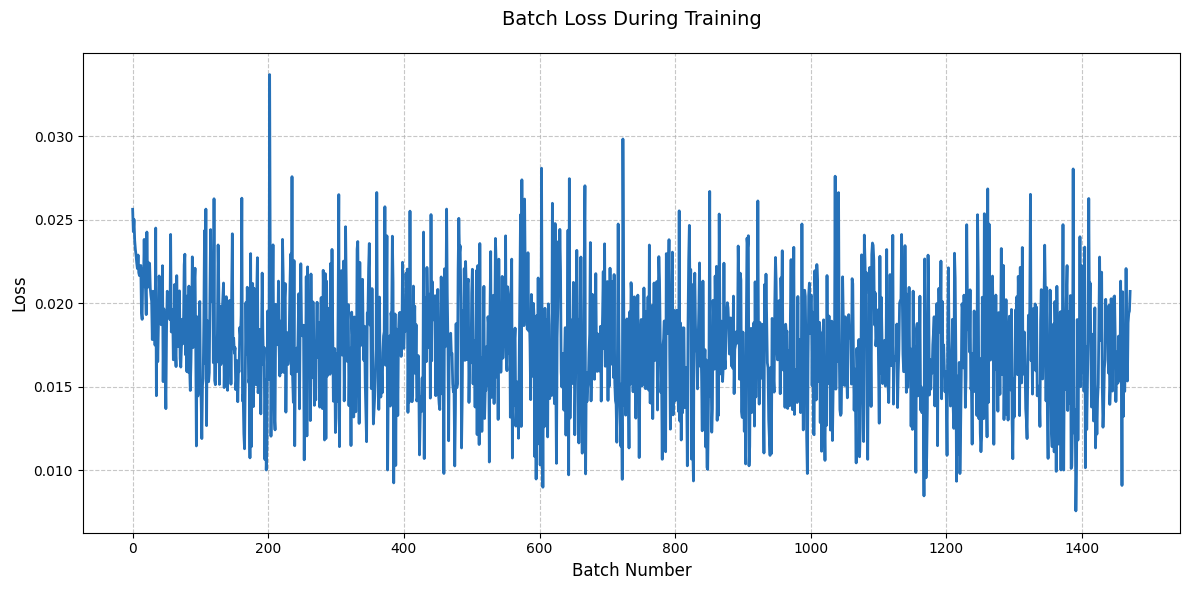

Reading metrics from: epoch_losses_20241211_132816.csv
Found 16 epoch records
Saved plot to: epoch_losses_plot_publication.pdf


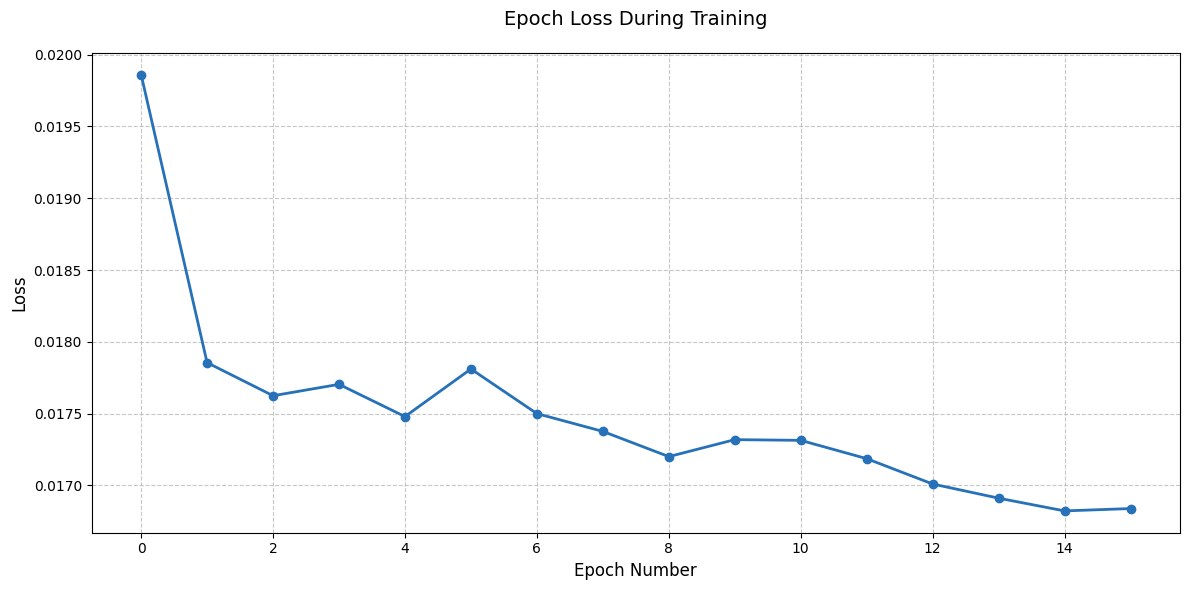

In [29]:
if __name__ == "__main__":
    ROOT_DIR = "/projectnb/ec523kb/projects/hemorrhage-classification/stage_2_train_sorted_nifti_pruned"
    
    print("Starting model training...")
    model, training_timestamp = train_improved_model(
        root_dir=ROOT_DIR,
        num_epochs=20,
        batch_size=16,
        learning_rate=1e-4
    )

    # Save the trained model
    torch.save(model.state_dict(), 'hemorrhage_model.pth')
    print("Model saved to hemorrhage_model.pth")

    # Plot the training metrics with correct filenames
    print("\nPlotting training metrics...")
    plot_training_metrics(f'batch_losses_{training_timestamp}.csv', metric_type='batch', display=True)
    plot_training_metrics(f'epoch_losses_{training_timestamp}.csv', metric_type='epoch', display=True)


Analyzing new case...

Predicted Hemorrhage Types:
----------------------------------------
epidural: 0.379
intraparenchymal: 0.360
intraventricular: 0.354
subarachnoid: 0.359
subdural: 0.317
any: 0.338


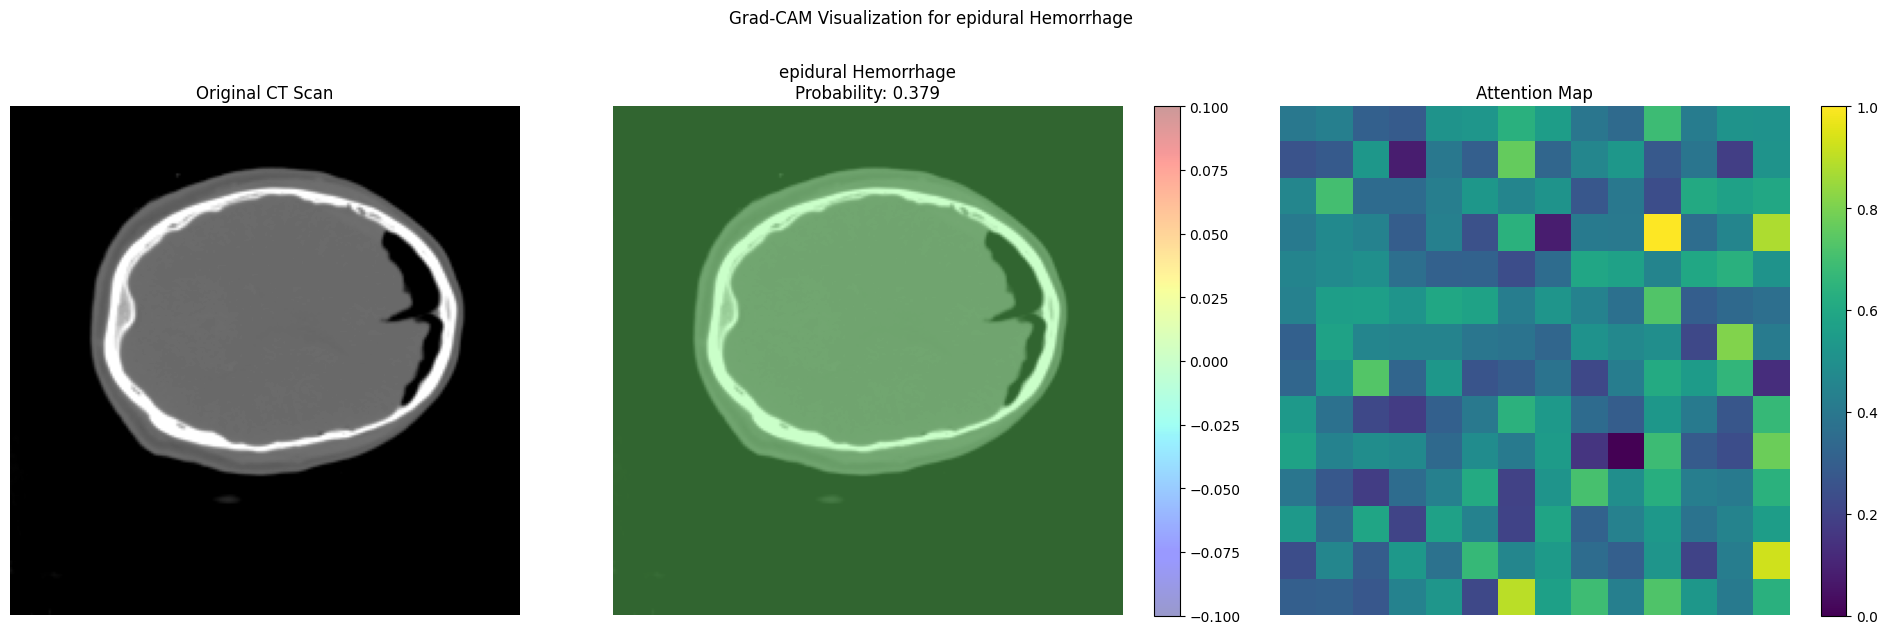

Saved Grad-CAM visualization for epidural to gradcam_results/gradcam_epidural.pdf


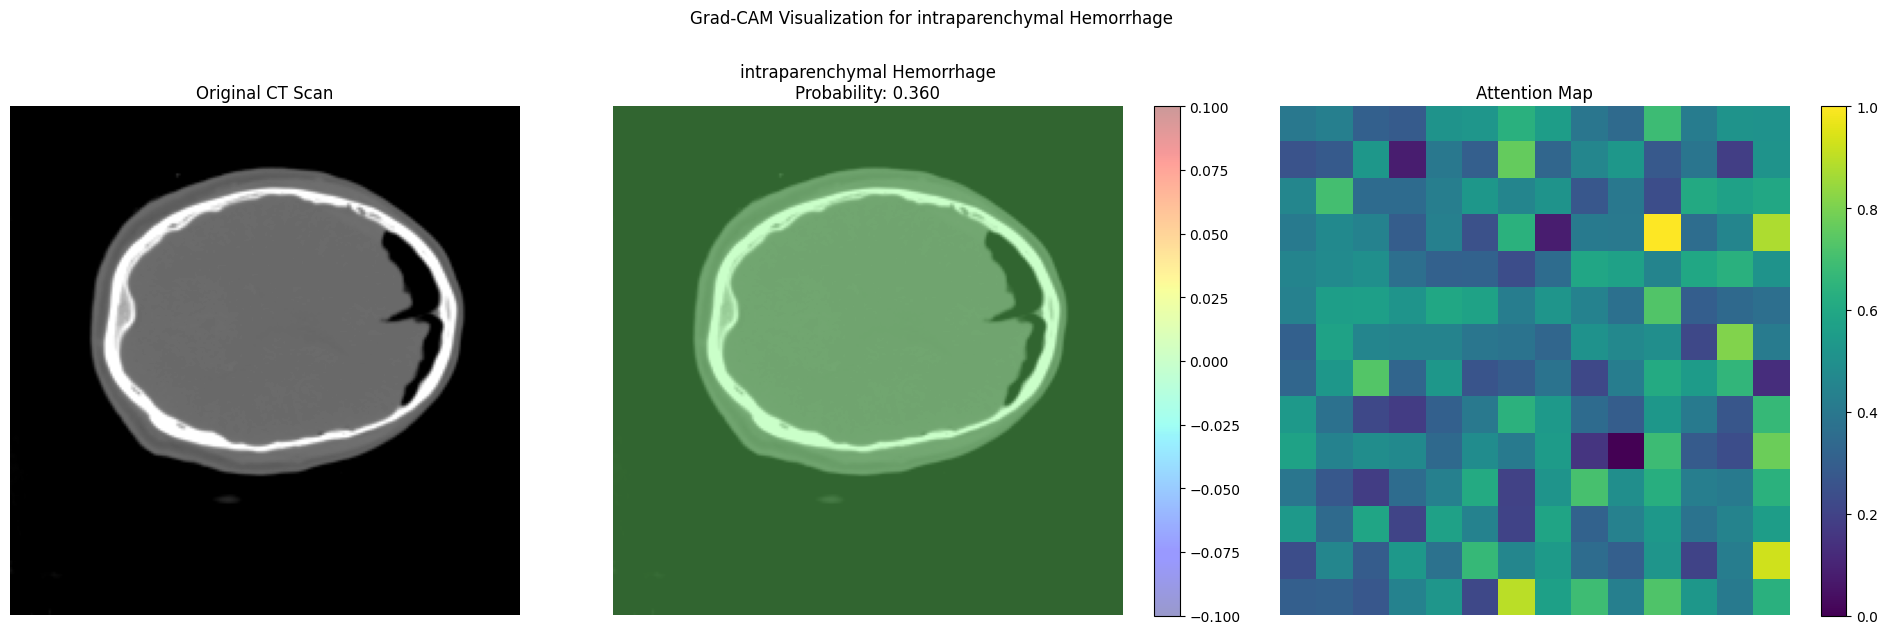

Saved Grad-CAM visualization for intraparenchymal to gradcam_results/gradcam_intraparenchymal.pdf


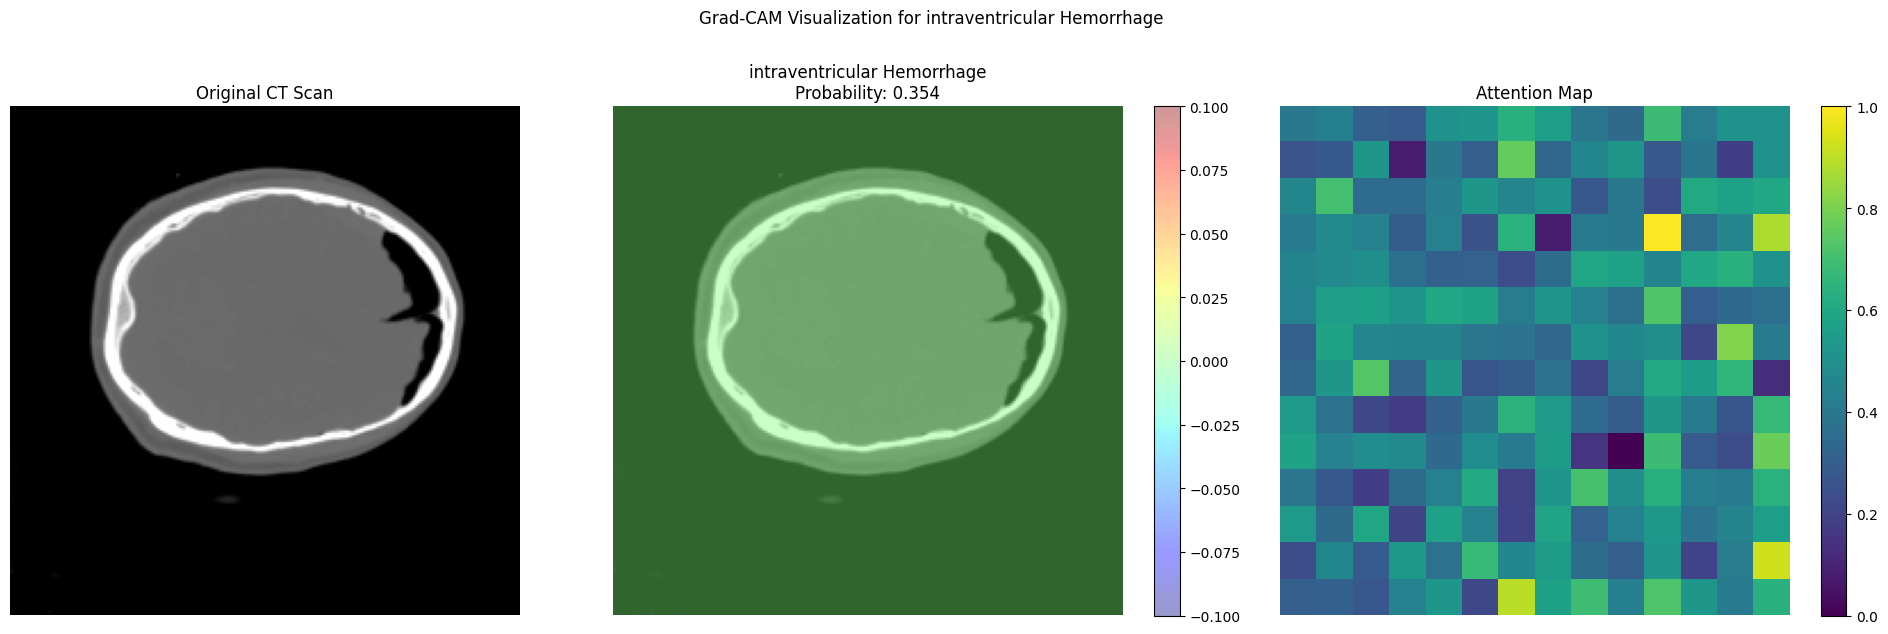

Saved Grad-CAM visualization for intraventricular to gradcam_results/gradcam_intraventricular.pdf


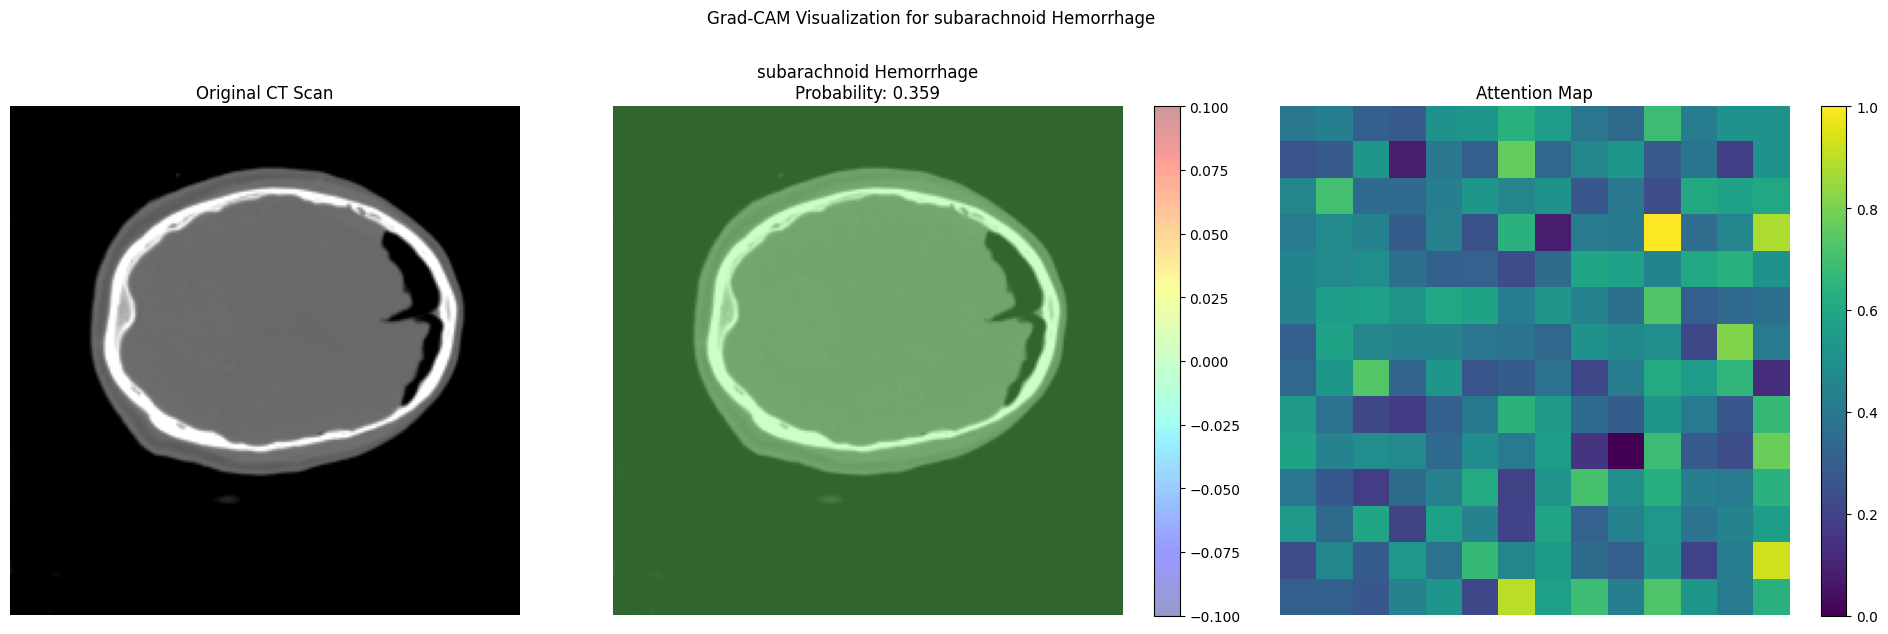

Saved Grad-CAM visualization for subarachnoid to gradcam_results/gradcam_subarachnoid.pdf


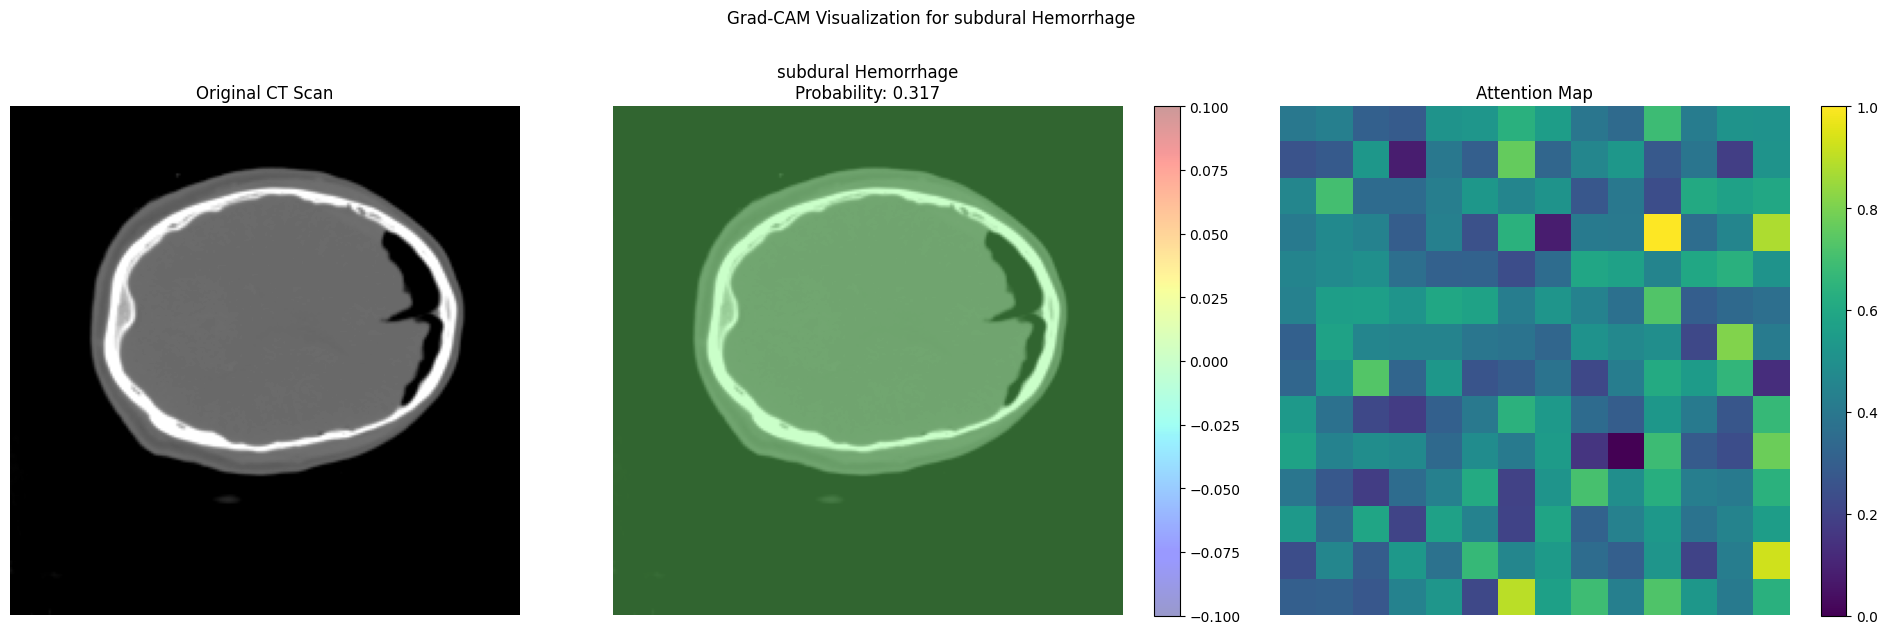

Saved Grad-CAM visualization for subdural to gradcam_results/gradcam_subdural.pdf


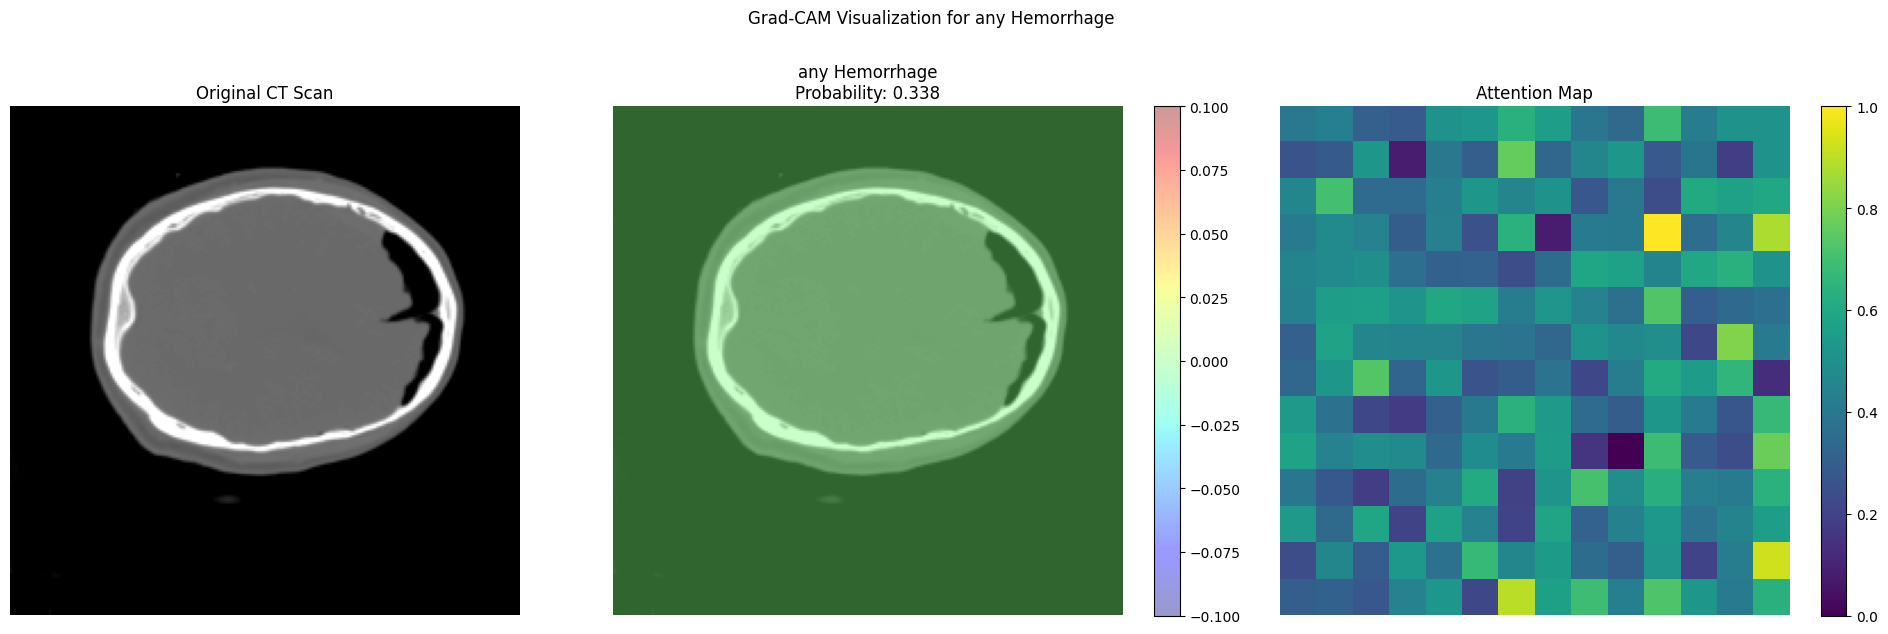

Saved Grad-CAM visualization for any to gradcam_results/gradcam_any.pdf


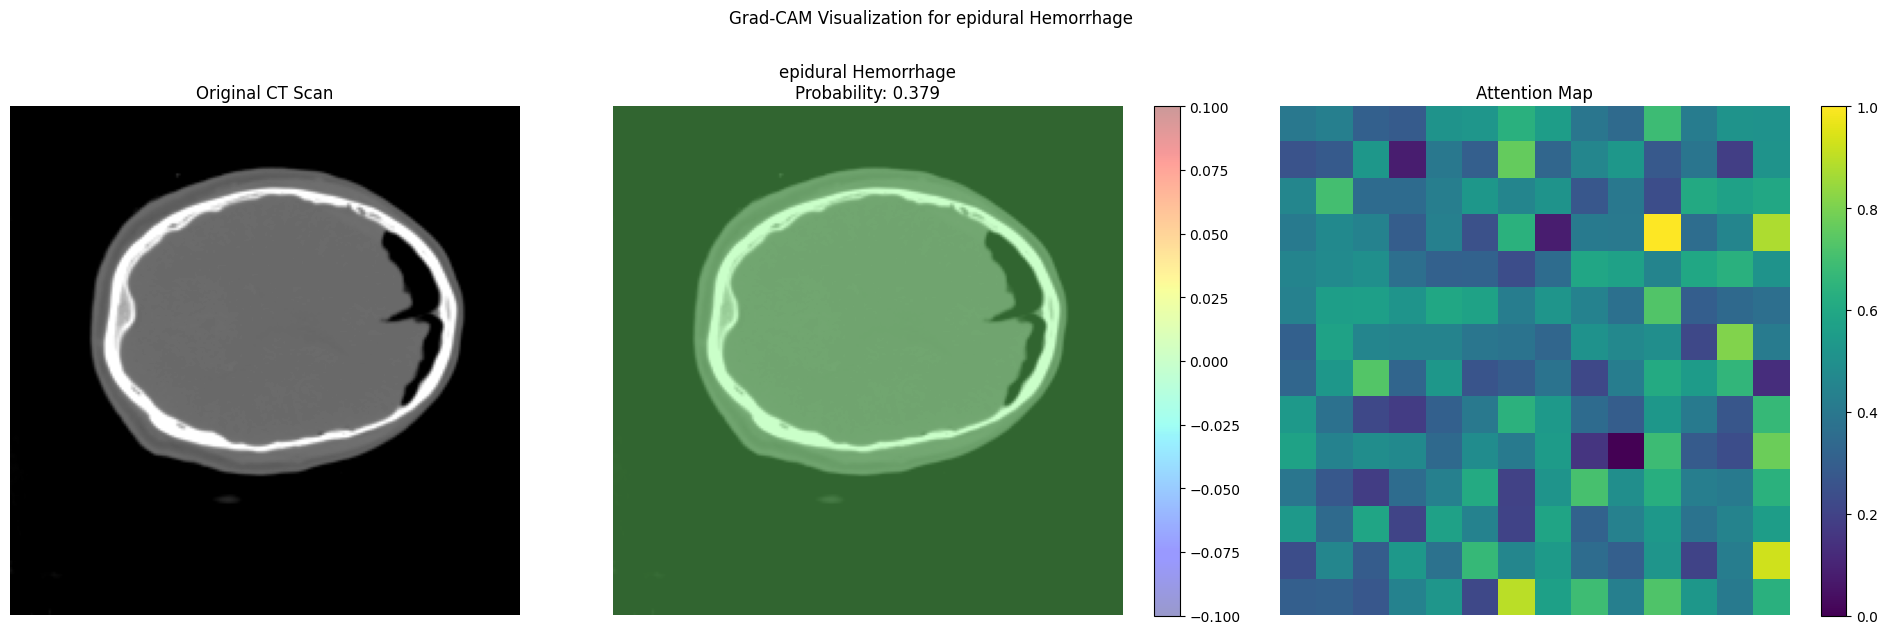

Saved Grad-CAM visualization for epidural to analysis_results_ID_1e03295964/gradcam/gradcam_epidural.pdf


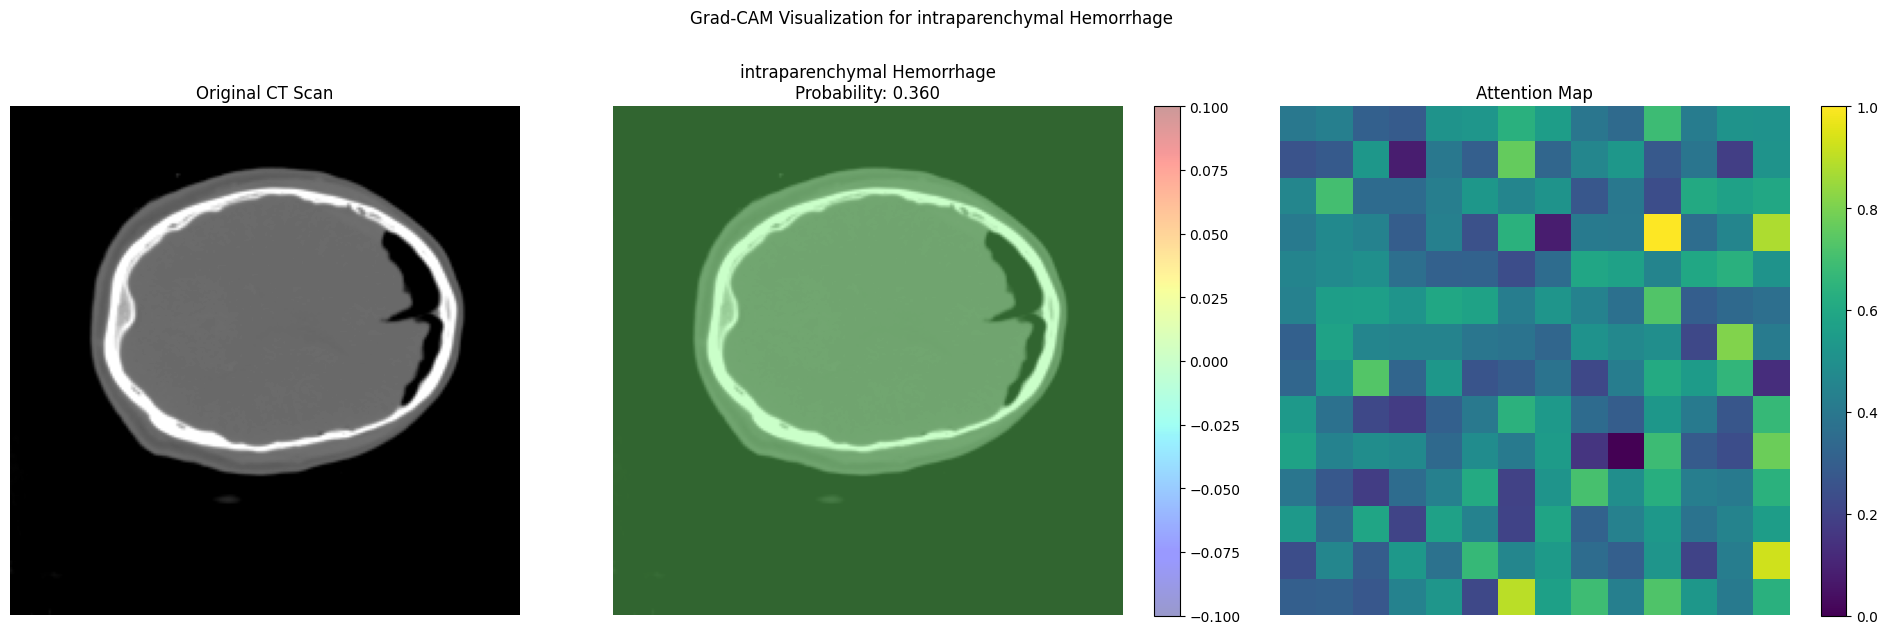

Saved Grad-CAM visualization for intraparenchymal to analysis_results_ID_1e03295964/gradcam/gradcam_intraparenchymal.pdf


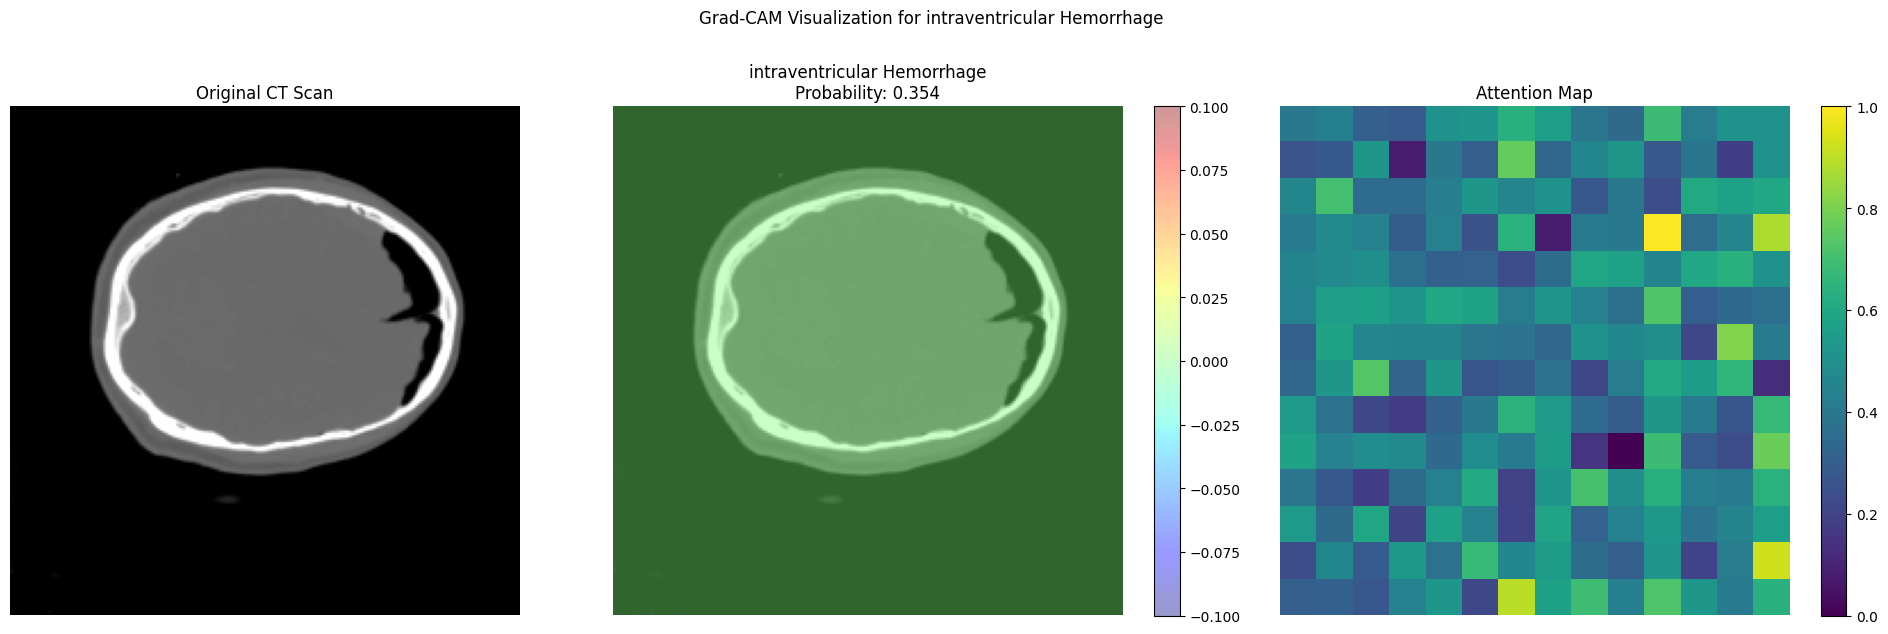

Saved Grad-CAM visualization for intraventricular to analysis_results_ID_1e03295964/gradcam/gradcam_intraventricular.pdf


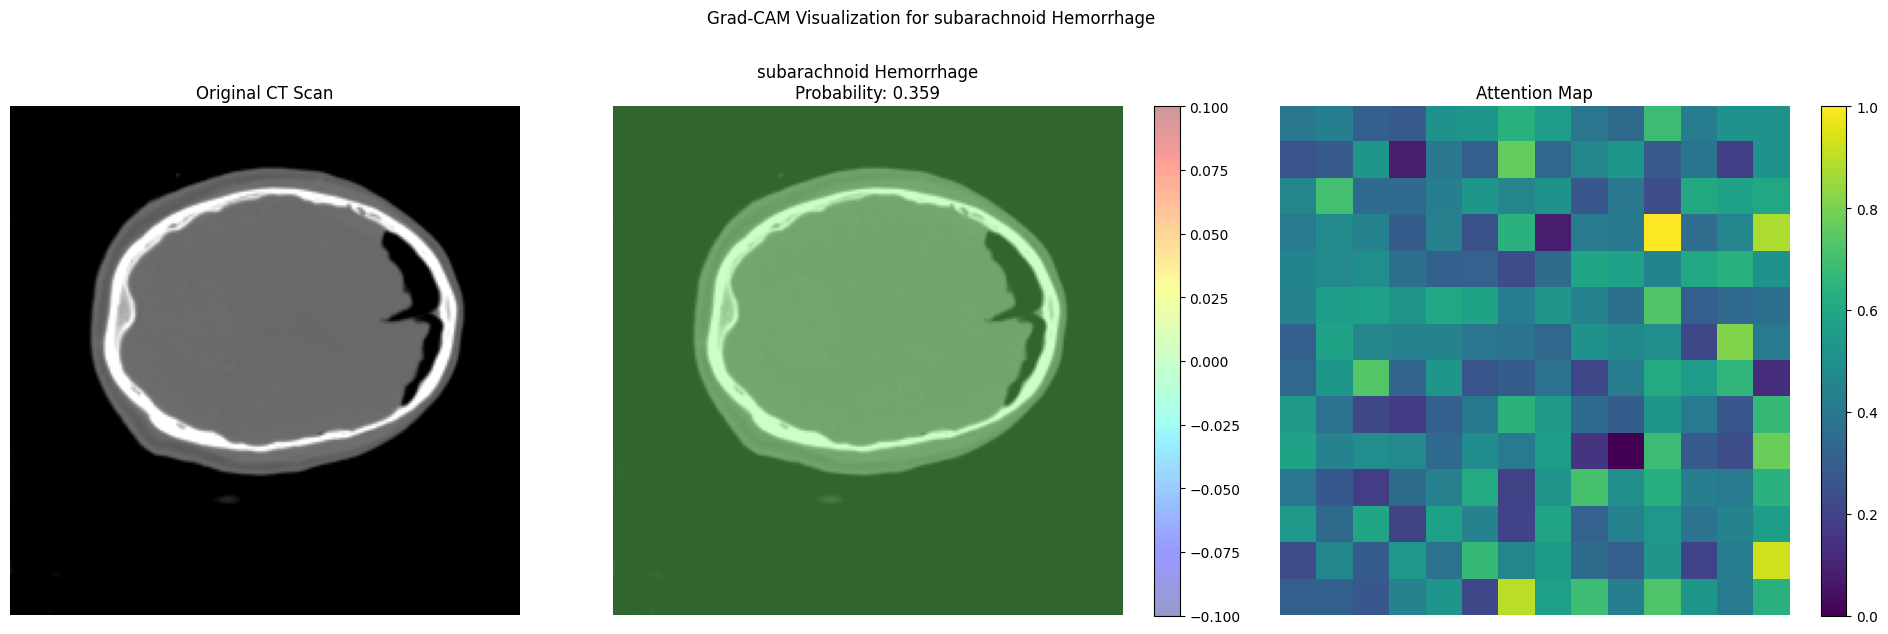

Saved Grad-CAM visualization for subarachnoid to analysis_results_ID_1e03295964/gradcam/gradcam_subarachnoid.pdf


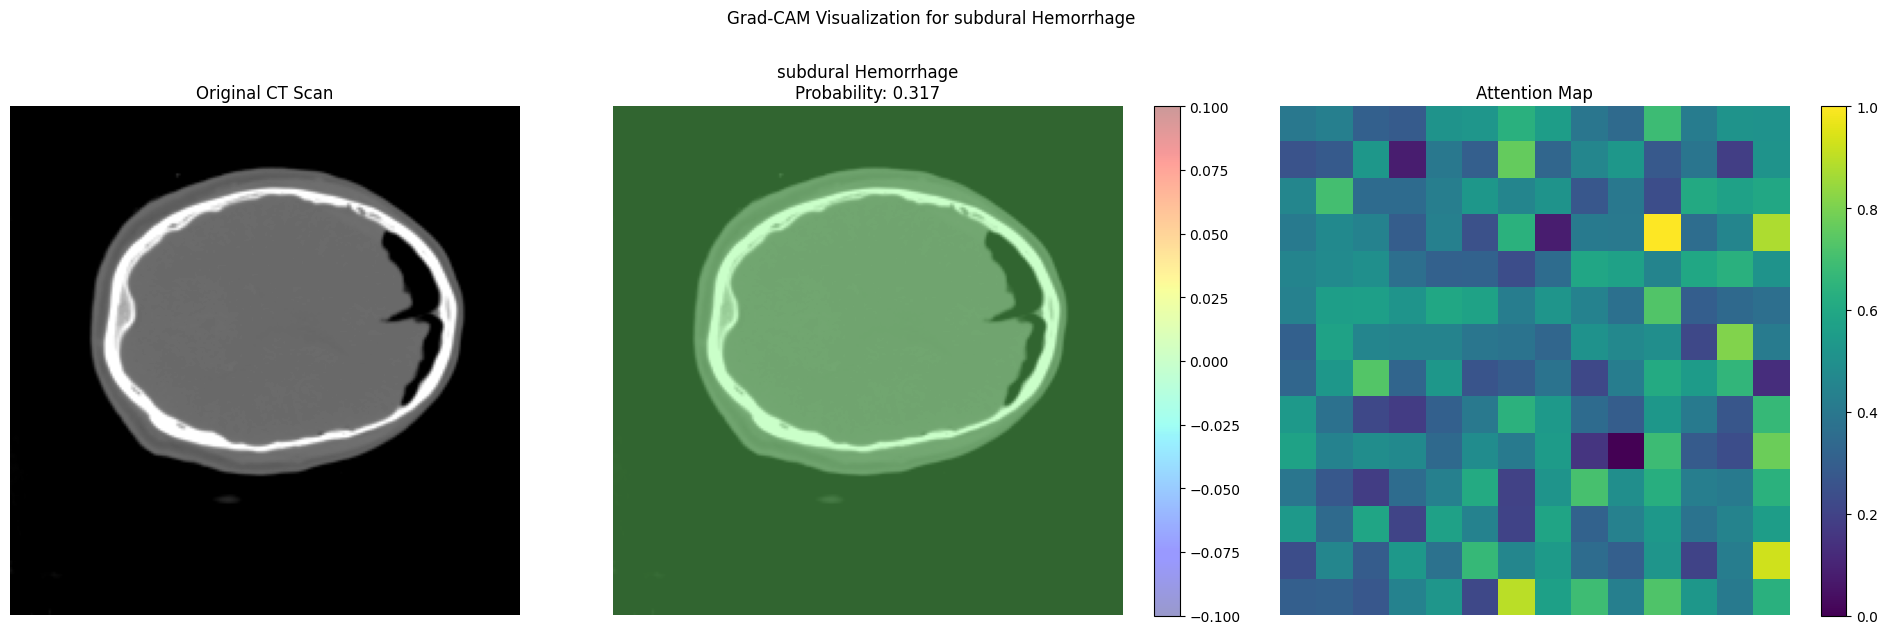

Saved Grad-CAM visualization for subdural to analysis_results_ID_1e03295964/gradcam/gradcam_subdural.pdf


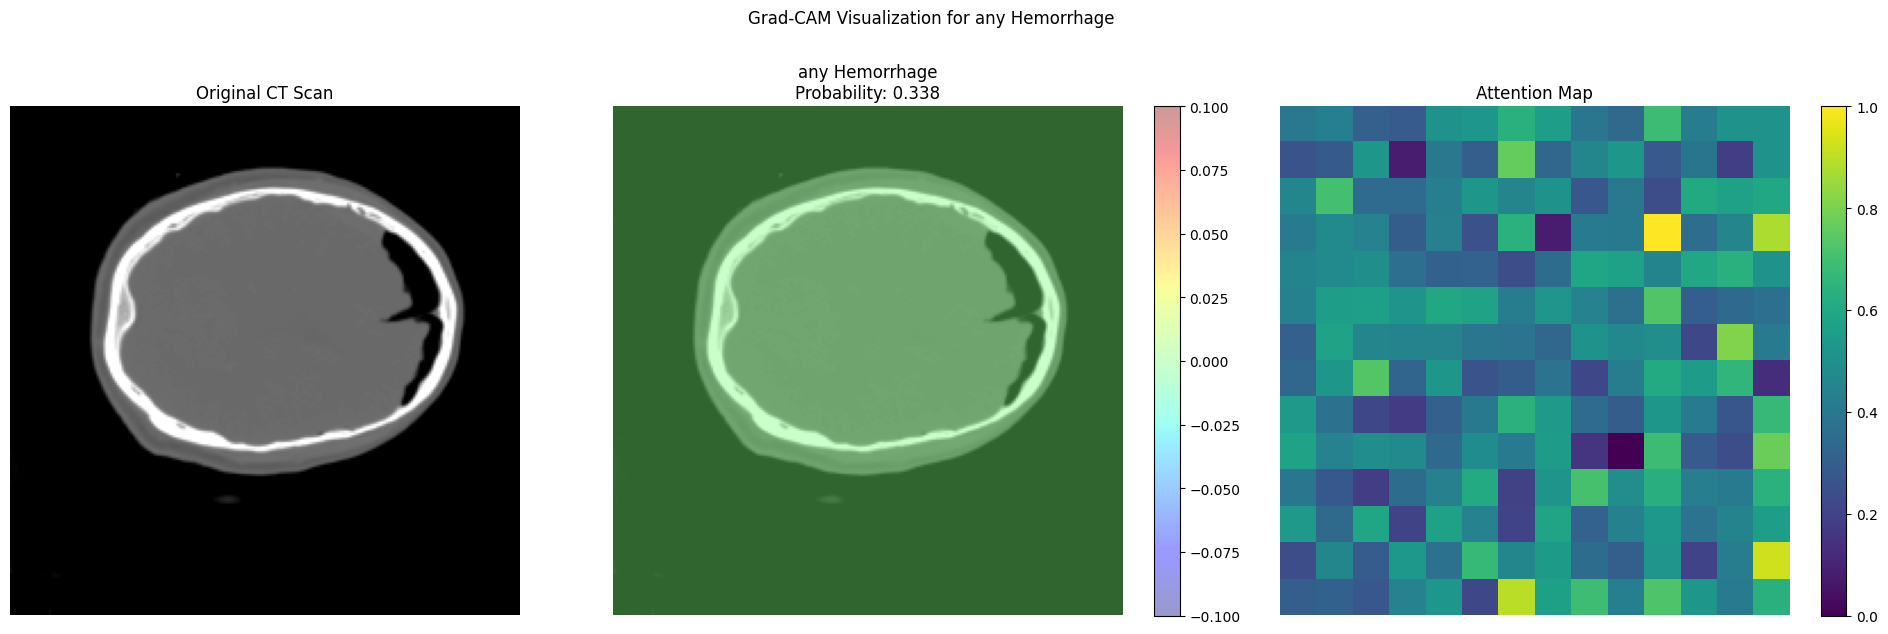

Saved Grad-CAM visualization for any to analysis_results_ID_1e03295964/gradcam/gradcam_any.pdf
Error in create_attention_heatmap for epidural: shape '[14, 14]' is invalid for input of size 38416
Error in create_attention_heatmap for intraparenchymal: shape '[14, 14]' is invalid for input of size 38416
Error in create_attention_heatmap for intraventricular: shape '[14, 14]' is invalid for input of size 38416
Error in create_attention_heatmap for subarachnoid: shape '[14, 14]' is invalid for input of size 38416
Error in create_attention_heatmap for subdural: shape '[14, 14]' is invalid for input of size 38416
Error in create_attention_heatmap for any: shape '[14, 14]' is invalid for input of size 38416


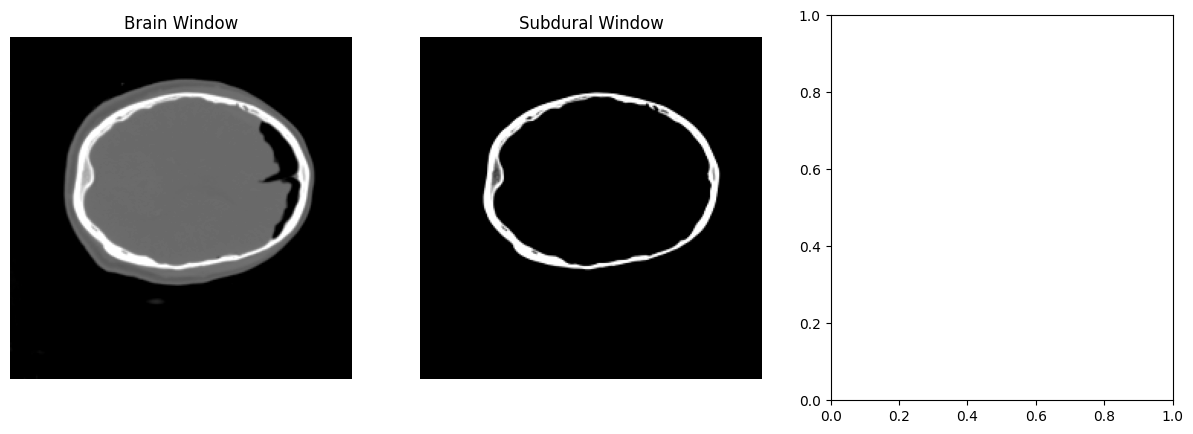

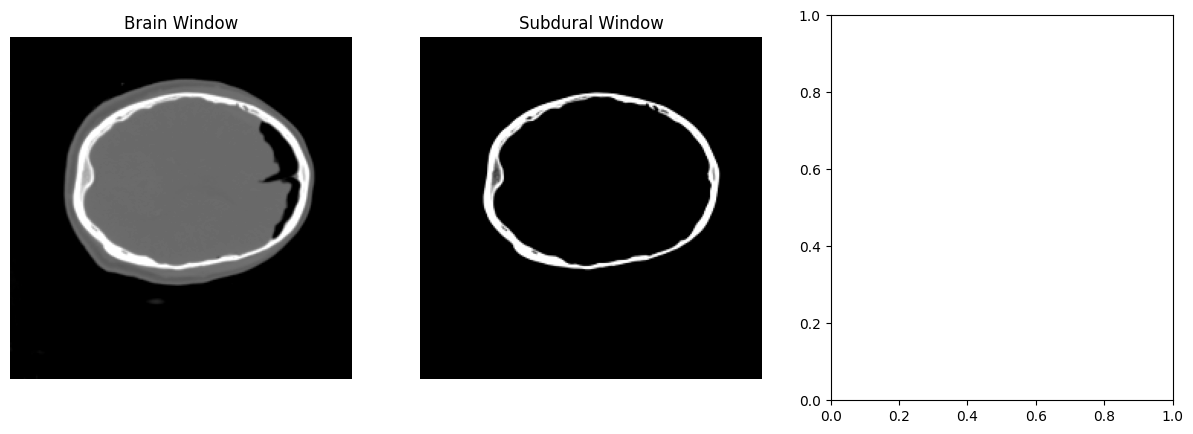

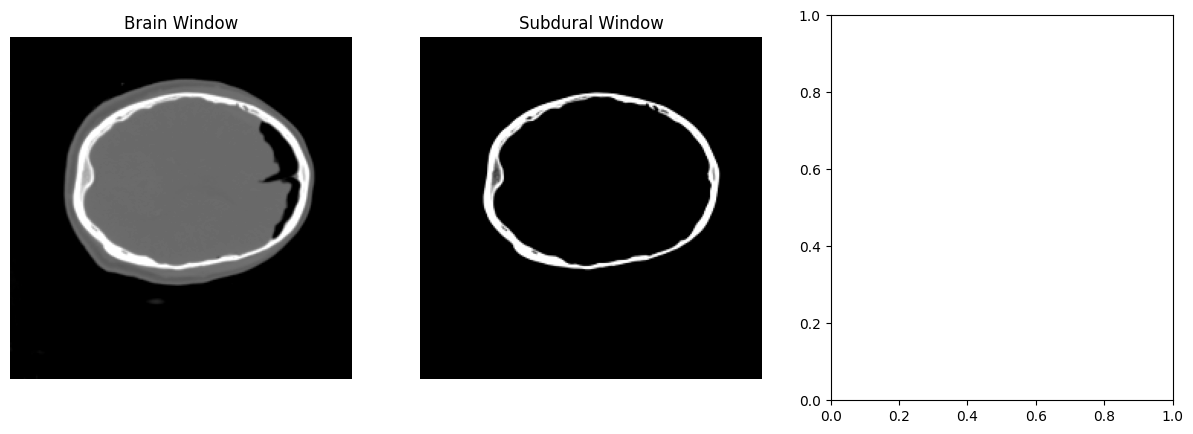

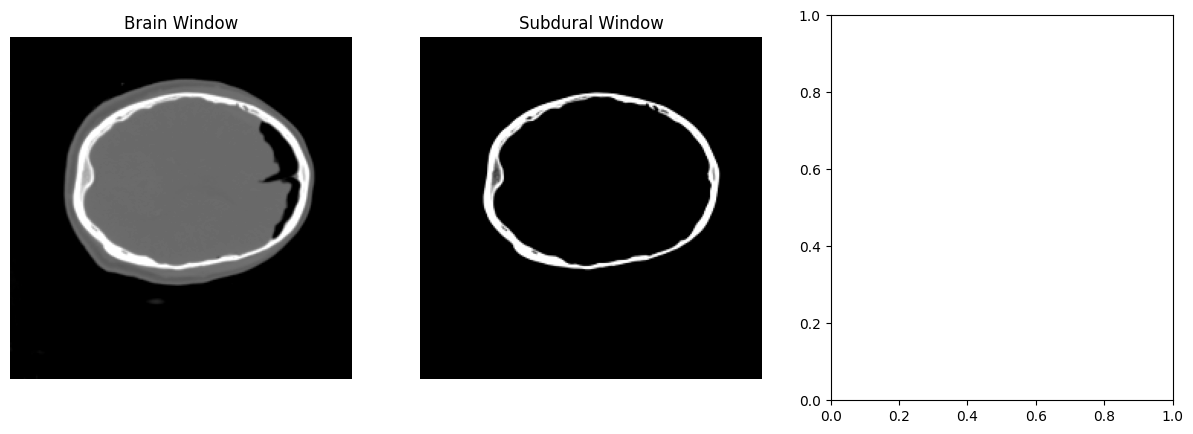

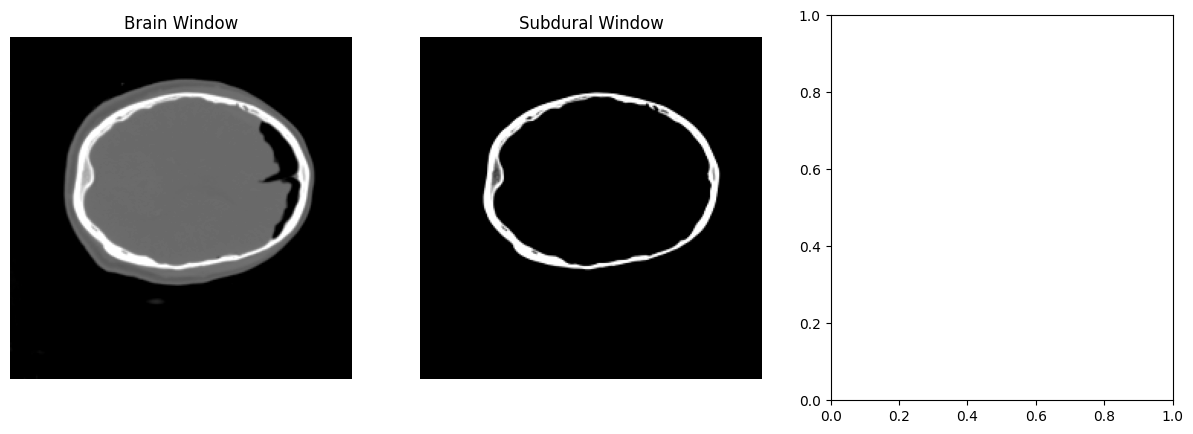

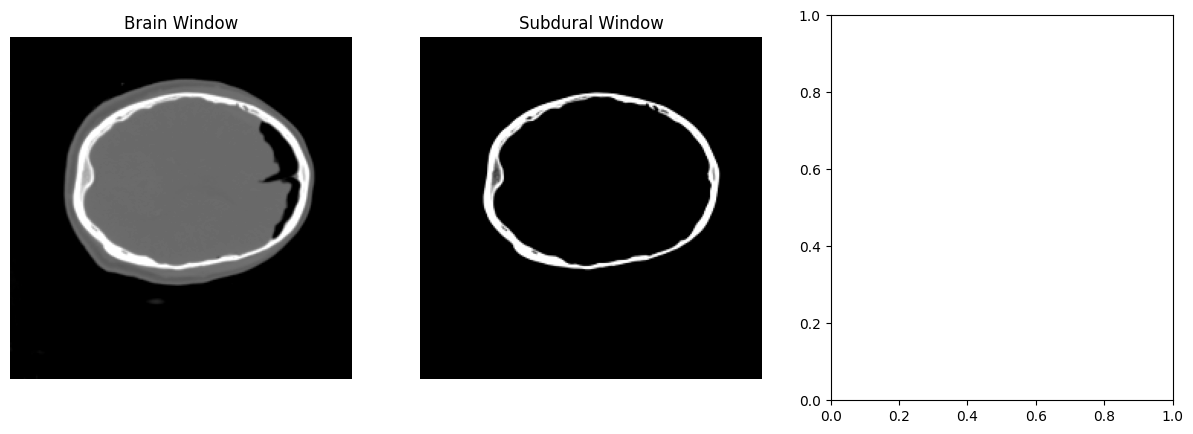

In [30]:
# Test another specific case
print("\nAnalyzing new case...")
test_file = "/projectnb/ec523kb/projects/hemorrhage-classification/stage_2_train_sorted_nifti_pruned/ID_1e03295964/ID_1e03295964.nii.gz"  # Replace with new file path
# results, image = analyze_hemorrhage_with_gradcam(model, test_file)
# visualize_gradcam_results(image, results, display=True)

output = analyze_hemorrhage_with_gradcam(model, test_file)  # Now returns a dictionary
visualize_gradcam_results(output['image'], output['results'], display=True)

# Option 2: Using comprehensive visualization
visualize_comprehensive_results(output, save_dir='analysis_results_ID_1e03295964')

In [27]:
print("\nAnalyzing new case...")
test_file = "/projectnb/ec523kb/projects/hemorrhage-classification/stage_2_train_sorted_nifti_pruned/ID_2ad3829f51/ID_2ad3829f51.nii.gz"  # Replace with new file path
results, image = analyze_hemorrhage_with_gradcam(model, test_file)
visualize_gradcam_results(image, results, display=True)


Analyzing new case...

Predicted Hemorrhage Types:
----------------------------------------
epidural: 0.401
intraparenchymal: 0.382
intraventricular: 0.386
subarachnoid: 0.399
subdural: 0.352
any: 0.339


ValueError: too many values to unpack (expected 2)

In [28]:
# intraparenchymal
print("\nAnalyzing new case...")
test_file = "/projectnb/ec523kb/projects/hemorrhage-classification/stage_2_train_sorted_nifti_pruned/ID_2dfd378443/ID_2dfd378443.nii.gz"  # Replace with new file path
results, image = analyze_hemorrhage_with_gradcam(model, test_file)
visualize_gradcam_results(image, results, display=True)


Analyzing new case...

Predicted Hemorrhage Types:
----------------------------------------
epidural: 0.401
intraparenchymal: 0.382
intraventricular: 0.386
subarachnoid: 0.399
subdural: 0.352
any: 0.339


ValueError: too many values to unpack (expected 2)